By:  David R. Torres<br>
Flatiron School<br>
Github repo: https://github.com/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/tree/master

# **Model 4 Time Series Notebook**

### **Introduction**
Business Problem: I am a consultant for Premium Real Estate, LLC.  The firm asked me to provide analysis and recommendations for investing in the top 5 zipcodes in Brooklyn that will provide the highest return on investment.  The investment firm is looking for short-term investments with the highest returns over a 3 year period.  The investment firm isn't looking for long term investments.<br>
<br>
I will make recommendations based on the market forecasting of real estate prices in Brooklyn. The top 5 zipcodes or 'best' zipcodes will be those with the highest ROI over the 3 year period.<br>
<br>
For the task, I analyzed real estate sales data from Zillow which covers time period 4-1-1996 to 4-1-2018.<br>
I used an auto_arima model to conduct a gridsearch and find the lowest AIC scores and corresponding p,d,qs and Seasonal P,D,Qs.  I used a SARIMA model to make predictions regarding the test data so I could get an idea of how my models were working with making predictions.  I used RMSE to evaluate how my models were performing.  I then made models to perform dynamic forecasts for 3 years.<br>


In [1]:
print('Notebook 12-18-20')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

Notebook 12-18-20


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#pip install PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
#zillow = pd.read_csv('/content/gdrive/My Drive/data/zillow_data.csv') 
zillow = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-v2-1-onl01-dtsc-ft-070620/master/time-series/zillow_data.csv')

In [6]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

RegionID  Zipcode      City State              Metro CountyName  SizeRank  \
0     84654    60657   Chicago    IL            Chicago       Cook         1   
1     90668    75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982    77494      Katy    TX            Houston     Harris         3   
3     84616    60614   Chicago    IL            Chicago       Cook         4   
4     93144    79936   El Paso    TX            El Paso    El Paso         5   

    1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
0  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800  1009600   
1  235700.0  236900.0  236700.0  ...   308000   310000   312500   314100   
2  210400.0  212200.0  212200.0  ...   321000   320600   320200   320400   
3  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400  1291500   
4   77300.0   77300.0   77300.0  ...   119100   119400   120000   120300   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
1   315000   316600   318100   319600   321100   321800  
2   320800   321200   321200   323000   326900   329900  
3  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

### Melted Data Function

In [7]:
def melt_data(df):
    """
    df - is the dataframe
    This is a time series so I need a column for dates to become the index.
    melt.() function sets up dataframe to to do this.  
    """
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [8]:
all_zipcodes = melt_data(zillow)

In [9]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [10]:
all_zipcodes.head(10)

RegionID  Zipcode           City State              Metro     CountyName  \
0     84654    60657        Chicago    IL            Chicago           Cook   
1     90668    75070       McKinney    TX  Dallas-Fort Worth         Collin   
2     91982    77494           Katy    TX            Houston         Harris   
3     84616    60614        Chicago    IL            Chicago           Cook   
4     93144    79936        El Paso    TX            El Paso        El Paso   
5     91733    77084        Houston    TX            Houston         Harris   
6     61807    10467       New York    NY           New York          Bronx   
7     84640    60640        Chicago    IL            Chicago           Cook   
8     91940    77449           Katy    TX            Houston         Harris   
9     97564    94109  San Francisco    CA      San Francisco  San Francisco   

   SizeRank      Month  MeanValue  
0         1 1996-04-01   334200.0  
1         2 1996-04-01   235700.0  
2         3 1996-04-01   210400.0  
3         4 1996-04-01   498100.0  
4         5 1996-04-01    77300.0  
5         6 1996-04-01    95000.0  
6         7 1996-04-01   152900.0  
7         8 1996-04-01   216500.0  
8         9 1996-04-01    95400.0  
9        10 1996-04-01   766000.0

In [11]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

RegionID  Zipcode      City State     Metro CountyName  SizeRank  \
10          62037    11226  New York    NY  New York      Kings        11   
13          62045    11235  New York    NY  New York      Kings        14   
47          62040    11230  New York    NY  New York      Kings        48   
49          62020    11209  New York    NY  New York      Kings        50   
53          62023    11212  New York    NY  New York      Kings        54   
...           ...      ...       ...   ...       ...        ...       ...   
3887683     62035    11224  New York    NY  New York      Kings       812   
3888027     62033    11222  New York    NY  New York      Kings      1156   
3888306     62016    11205  New York    NY  New York      Kings      1435   
3888406     62028    11217  New York    NY  New York      Kings      1535   
3890600     62038    11228  New York    NY  New York      Kings      3729   

             Month  MeanValue  
10      1996-04-01   162000.0  
13      1996-04-01   190500.0  
47      1996-04-01   230100.0  
49      1996-04-01   255700.0  
53      1996-04-01   125000.0  
...            ...        ...  
3887683 2018-04-01   517900.0  
3888027 2018-04-01  1721100.0  
3888306 2018-04-01  2248400.0  
3888406 2018-04-01  3656000.0  
3890600 2018-04-01   915300.0  

[7141 rows x 9 columns]

In [12]:
#for loop gets the monthly mean sales price for each Brooklyn zipcode and puts it in dictionary. 

test_dict = {}

for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [13]:
test_dict

{11226: Month
 1996-04-01    162000.0
 1996-05-01    162300.0
 1996-06-01    162600.0
 1996-07-01    163000.0
 1996-08-01    163400.0
                 ...   
 2017-12-01    887800.0
 2018-01-01    890500.0
 2018-02-01    901700.0
 2018-03-01    930700.0
 2018-04-01    963200.0
 Freq: MS, Name: 11226, Length: 265, dtype: float64,
 11235: Month
 1996-04-01    190500.0
 1996-05-01    191000.0
 1996-06-01    191500.0
 1996-07-01    192000.0
 1996-08-01    192500.0
                 ...   
 2017-12-01    799700.0
 2018-01-01    806600.0
 2018-02-01    810600.0
 2018-03-01    813400.0
 2018-04-01    816200.0
 Freq: MS, Name: 11235, Length: 265, dtype: float64,
 11230: Month
 1996-04-01     230100.0
 1996-05-01     230800.0
 1996-06-01     231500.0
 1996-07-01     232100.0
 1996-08-01     232800.0
                 ...    
 2017-12-01    1102400.0
 2018-01-01    1120200.0
 2018-02-01    1141600.0
 2018-03-01    1170000.0
 2018-04-01    1195400.0
 Freq: MS, Name: 11230, Length: 265, dtype: float

In [14]:
zip_df = pd.concat(test_dict, axis=1)

In [15]:
len(zip_df)

265

### **Dataframe of Brooklyn Zipcodes** 

In [16]:
type(zip_df[11226])

pandas.core.series.Series

In [17]:
zip_df.head()

11226     11235     11230     11209     11212     11214  \
Month                                                                    
1996-04-01  162000.0  190500.0  230100.0  255700.0  125000.0  191000.0   
1996-05-01  162300.0  191000.0  230800.0  256600.0  125000.0  191200.0   
1996-06-01  162600.0  191500.0  231500.0  257300.0  125000.0  191500.0   
1996-07-01  163000.0  192000.0  232100.0  258100.0  125000.0  191900.0   
1996-08-01  163400.0  192500.0  232800.0  258900.0  125100.0  192100.0   

               11221     11229     11234     11215  ...     11203     11220  \
Month                                               ...                       
1996-04-01  133700.0  183900.0  172300.0  225700.0  ...  149000.0  188500.0   
1996-05-01  133700.0  184200.0  172100.0  227500.0  ...  149200.0  188700.0   
1996-06-01  133700.0  184500.0  171900.0  229400.0  ...  149400.0  188800.0   
1996-07-01  133700.0  184800.0  171600.0  231600.0  ...  149600.0  189000.0   
1996-08-01  133900.0  185000.0  171400.0  234100.0  ...  149700.0  189400.0   

               11216     11210     11224     11222     11228  11238  11205  \
Month                                                                        
1996-04-01  146100.0  187300.0  158000.0  149200.0  219300.0    NaN    NaN   
1996-05-01  146600.0  187300.0  157300.0  148400.0  219600.0    NaN    NaN   
1996-06-01  147200.0  187200.0  156700.0  147500.0  219900.0    NaN    NaN   
1996-07-01  147700.0  187100.0  156100.0  146600.0  220200.0    NaN    NaN   
1996-08-01  148400.0  187000.0  155600.0  146000.0  220600.0    NaN    NaN   

            11217  
Month              
1996-04-01    NaN  
1996-05-01    NaN  
1996-06-01    NaN  
1996-07-01    NaN  
1996-08-01    NaN  

[5 rows x 28 columns]

In [18]:
zip_df.tail()

11226     11235      11230      11209     11212     11214  \
Month                                                                      
2017-12-01  887800.0  799700.0  1102400.0  1018900.0  414900.0  826300.0   
2018-01-01  890500.0  806600.0  1120200.0  1023500.0  422300.0  827600.0   
2018-02-01  901700.0  810600.0  1141600.0  1029200.0  426300.0  830500.0   
2018-03-01  930700.0  813400.0  1170000.0  1023000.0  427100.0  837300.0   
2018-04-01  963200.0  816200.0  1195400.0  1015800.0  428400.0  844100.0   

                11221     11229     11234      11215  ...     11203     11220  \
Month                                                 ...                       
2017-12-01   998100.0  741000.0  575000.0  2287100.0  ...  474500.0  903000.0   
2018-01-01  1000900.0  748100.0  579400.0  2288900.0  ...  475300.0  906500.0   
2018-02-01  1015400.0  755800.0  583200.0  2265300.0  ...  474800.0  910700.0   
2018-03-01  1037300.0  766200.0  589400.0  2244900.0  ...  481000.0  915600.0   
2018-04-01  1048700.0  775500.0  593300.0  2243900.0  ...  489900.0  917900.0   

                11216     11210     11224      11222     11228      11238  \
Month                                                                       
2017-12-01  1545700.0  802900.0  498700.0  1651200.0  902200.0  2768900.0   
2018-01-01  1540200.0  809100.0  502000.0  1661800.0  909000.0  2810700.0   
2018-02-01  1553600.0  814500.0  505600.0  1672800.0  912800.0  2848100.0   
2018-03-01  1578400.0  816900.0  511600.0  1694000.0  913900.0  2869600.0   
2018-04-01  1598700.0  819600.0  517900.0  1721100.0  915300.0  2885300.0   

                11205      11217  
Month                             
2017-12-01  2251000.0  3404100.0  
2018-01-01  2251600.0  3413800.0  
2018-02-01  2245300.0  3482900.0  
2018-03-01  2243700.0  3588100.0  
2018-04-01  2248400.0  3656000.0  

[5 rows x 28 columns]

In [19]:
len(zip_df.columns)

28

In [20]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [21]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

#### **NaN Values**

In [22]:
zip_df.bfill(inplace=True)

In [23]:
zip_df.isna().sum()

11226    0
11235    0
11230    0
11209    0
11212    0
11214    0
11221    0
11229    0
11234    0
11215    0
11211    0
11233    0
11236    0
11218    0
11223    0
11208    0
11204    0
11219    0
11203    0
11220    0
11216    0
11210    0
11224    0
11222    0
11228    0
11238    0
11205    0
11217    0
dtype: int64

In [24]:
zip_df[11238].value_counts(dropna=False)

671200.0     94
1177800.0     2
1839100.0     1
1033400.0     1
2530000.0     1
             ..
2346900.0     1
665400.0      1
1237600.0     1
1361500.0     1
1638400.0     1
Name: 11238, Length: 171, dtype: int64

In [25]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

In [26]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

### **Graph of Price Trends of Brooklyn Zipcodes**

In [27]:
zip_df_1 = zip_df[[11217, 11238,11215,11212]]
zip_df_1.head(50)

11217     11238     11215     11212
Month                                              
1996-04-01  1037600.0  671200.0  225700.0  125000.0
1996-05-01  1037600.0  671200.0  227500.0  125000.0
1996-06-01  1037600.0  671200.0  229400.0  125000.0
1996-07-01  1037600.0  671200.0  231600.0  125000.0
1996-08-01  1037600.0  671200.0  234100.0  125100.0
1996-09-01  1037600.0  671200.0  236900.0  125100.0
1996-10-01  1037600.0  671200.0  239800.0  125000.0
1996-11-01  1037600.0  671200.0  242900.0  124800.0
1996-12-01  1037600.0  671200.0  246400.0  124600.0
1997-01-01  1037600.0  671200.0  249800.0  124500.0
1997-02-01  1037600.0  671200.0  252200.0  124500.0
1997-03-01  1037600.0  671200.0  253800.0  124500.0
1997-04-01  1037600.0  671200.0  255100.0  124500.0
1997-05-01  1037600.0  671200.0  256000.0  124700.0
1997-06-01  1037600.0  671200.0  256900.0  125100.0
1997-07-01  1037600.0  671200.0  258200.0  125500.0
1997-08-01  1037600.0  671200.0  260000.0  126000.0
1997-09-01  1037600.0  671200.0  262300.0  126400.0
1997-10-01  1037600.0  671200.0  264900.0  126800.0
1997-11-01  1037600.0  671200.0  268000.0  127000.0
1997-12-01  1037600.0  671200.0  271900.0  127100.0
1998-01-01  1037600.0  671200.0  276000.0  127500.0
1998-02-01  1037600.0  671200.0  279300.0  127900.0
1998-03-01  1037600.0  671200.0  282000.0  128200.0
1998-04-01  1037600.0  671200.0  284700.0  128700.0
1998-05-01  1037600.0  671200.0  287300.0  129400.0
1998-06-01  1037600.0  671200.0  290100.0  130100.0
1998-07-01  1037600.0  671200.0  293700.0  131000.0
1998-08-01  1037600.0  671200.0  297900.0  131800.0
1998-09-01  1037600.0  671200.0  302800.0  132600.0
1998-10-01  1037600.0  671200.0  308200.0  133300.0
1998-11-01  1037600.0  671200.0  314100.0  133700.0
1998-12-01  1037600.0  671200.0  321000.0  134100.0
1999-01-01  1037600.0  671200.0  327800.0  134600.0
1999-02-01  1037600.0  671200.0  333700.0  135300.0
1999-03-01  1037600.0  671200.0  338700.0  135900.0
1999-04-01  1037600.0  671200.0  343500.0  136700.0
1999-05-01  1037600.0  671200.0  348100.0  137600.0
1999-06-01  1037600.0  671200.0  352700.0  138600.0
1999-07-01  1037600.0  671200.0  358100.0  139700.0
1999-08-01  1037600.0  671200.0  364400.0  140900.0
1999-09-01  1037600.0  671200.0  371400.0  141800.0
1999-10-01  1037600.0  671200.0  378800.0  142700.0
1999-11-01  1037600.0  671200.0  386900.0  143300.0
1999-12-01  1037600.0  671200.0  396000.0  143700.0
2000-01-01  1037600.0  671200.0  404900.0  144300.0
2000-02-01  1037600.0  671200.0  412600.0  144900.0
2000-03-01  1037600.0  671200.0  419200.0  145500.0
2000-04-01  1037600.0  671200.0  425200.0  146100.0
2000-05-01  1037600.0  671200.0  430600.0  146900.0

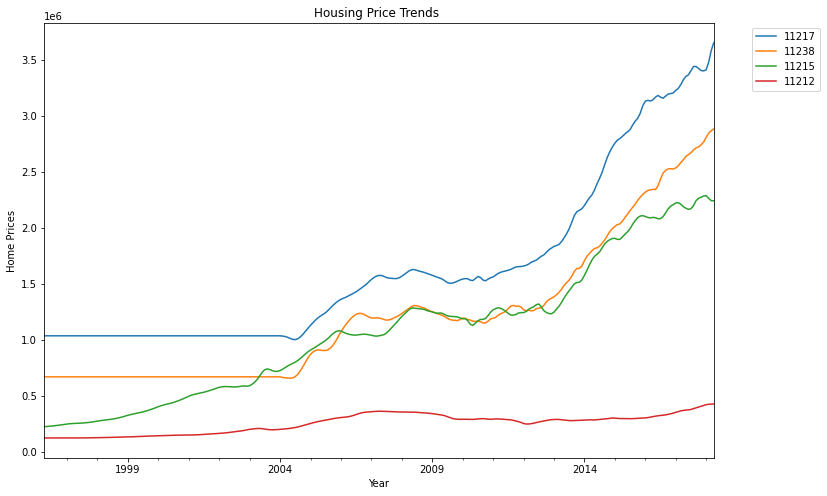

In [28]:
zip_df_1.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

Zipcodes: 11217, 11238, 11215 had the same values for monthly real easte so I created a plot eliminating these dates.  <br>

In [29]:
zip_no_nan = zip_df_1['2003-12-01':] 
zip_no_nan

11217      11238      11215     11212
Month                                                
2003-12-01  1037600.0   671200.0   720300.0  200100.0
2004-01-01  1037600.0   671200.0   727100.0  201900.0
2004-02-01  1035300.0   665400.0   739000.0  204100.0
2004-03-01  1031400.0   662500.0   754000.0  206200.0
2004-04-01  1024000.0   660200.0   768600.0  208400.0
...               ...        ...        ...       ...
2017-12-01  3404100.0  2768900.0  2287100.0  414900.0
2018-01-01  3413800.0  2810700.0  2288900.0  422300.0
2018-02-01  3482900.0  2848100.0  2265300.0  426300.0
2018-03-01  3588100.0  2869600.0  2244900.0  427100.0
2018-04-01  3656000.0  2885300.0  2243900.0  428400.0

[173 rows x 4 columns]

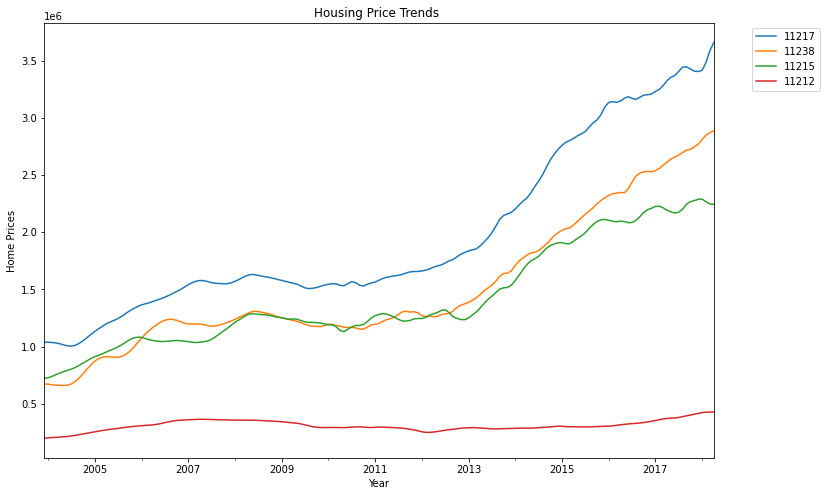

In [30]:
zip_no_nan.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

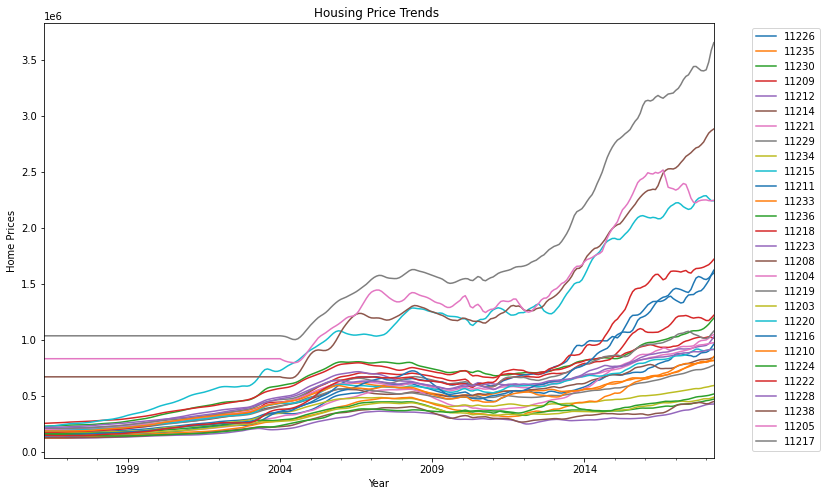

In [31]:
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

In [32]:
zip_df.tail()

11226     11235      11230      11209     11212     11214  \
Month                                                                      
2017-12-01  887800.0  799700.0  1102400.0  1018900.0  414900.0  826300.0   
2018-01-01  890500.0  806600.0  1120200.0  1023500.0  422300.0  827600.0   
2018-02-01  901700.0  810600.0  1141600.0  1029200.0  426300.0  830500.0   
2018-03-01  930700.0  813400.0  1170000.0  1023000.0  427100.0  837300.0   
2018-04-01  963200.0  816200.0  1195400.0  1015800.0  428400.0  844100.0   

                11221     11229     11234      11215  ...     11203     11220  \
Month                                                 ...                       
2017-12-01   998100.0  741000.0  575000.0  2287100.0  ...  474500.0  903000.0   
2018-01-01  1000900.0  748100.0  579400.0  2288900.0  ...  475300.0  906500.0   
2018-02-01  1015400.0  755800.0  583200.0  2265300.0  ...  474800.0  910700.0   
2018-03-01  1037300.0  766200.0  589400.0  2244900.0  ...  481000.0  915600.0   
2018-04-01  1048700.0  775500.0  593300.0  2243900.0  ...  489900.0  917900.0   

                11216     11210     11224      11222     11228      11238  \
Month                                                                       
2017-12-01  1545700.0  802900.0  498700.0  1651200.0  902200.0  2768900.0   
2018-01-01  1540200.0  809100.0  502000.0  1661800.0  909000.0  2810700.0   
2018-02-01  1553600.0  814500.0  505600.0  1672800.0  912800.0  2848100.0   
2018-03-01  1578400.0  816900.0  511600.0  1694000.0  913900.0  2869600.0   
2018-04-01  1598700.0  819600.0  517900.0  1721100.0  915300.0  2885300.0   

                11205      11217  
Month                             
2017-12-01  2251000.0  3404100.0  
2018-01-01  2251600.0  3413800.0  
2018-02-01  2245300.0  3482900.0  
2018-03-01  2243700.0  3588100.0  
2018-04-01  2248400.0  3656000.0  

[5 rows x 28 columns]

### **Train/Test Split**
Train data set is from 1996–04–01 to 2014–01–01. The length of our train data is 214 rows, or 214 time periods.<br>
 <br>
Test data set is from 2014–01–01 to 2018–04–01. The length of our test data is 52 rows, or 52 time periods. 
That is the value will use for our .predict() method. 


In [33]:
year = '2014-01-01'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [34]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 28)
(52, 28)


In [35]:
train_brk.tail()

11226     11235     11230     11209     11212     11214  \
Month                                                                    
2013-09-01  551600.0  545200.0  791000.0  787900.0  280900.0  602000.0   
2013-10-01  558900.0  547300.0  802300.0  796100.0  282200.0  607600.0   
2013-11-01  566200.0  550600.0  809000.0  799700.0  282500.0  608800.0   
2013-12-01  572600.0  554600.0  813000.0  806000.0  283300.0  608300.0   
2014-01-01  580700.0  558200.0  819000.0  813900.0  285200.0  612200.0   

               11221     11229     11234      11215  ...     11203     11220  \
Month                                                ...                       
2013-09-01  530100.0  524200.0  437100.0  1501900.0  ...  362700.0  657900.0   
2013-10-01  538200.0  527500.0  437800.0  1513200.0  ...  362600.0  667100.0   
2013-11-01  545800.0  530400.0  437700.0  1516200.0  ...  361700.0  669800.0   
2013-12-01  556100.0  533500.0  438900.0  1536500.0  ...  361000.0  670500.0   
2014-01-01  569100.0  537700.0  441500.0  1577500.0  ...  361000.0  674600.0   

               11216     11210     11224     11222     11228      11238  \
Month                                                                     
2013-09-01  744700.0  544400.0  409800.0  863400.0  660800.0  1613500.0   
2013-10-01  752500.0  546500.0  397700.0  866600.0  667100.0  1638400.0   
2013-11-01  757800.0  549200.0  387300.0  870800.0  671500.0  1640700.0   
2013-12-01  766200.0  554300.0  382900.0  888300.0  677300.0  1661500.0   
2014-01-01  777900.0  561500.0  380800.0  924400.0  685900.0  1709200.0   

                11205      11217  
Month                             
2013-09-01  1640100.0  2111700.0  
2013-10-01  1658800.0  2146000.0  
2013-11-01  1659500.0  2158600.0  
2013-12-01  1670200.0  2173100.0  
2014-01-01  1700200.0  2202400.0  

[5 rows x 28 columns]

In [36]:
test_brk.head()

11226     11235     11230     11209     11212     11214  \
Month                                                                    
2014-01-01  580700.0  558200.0  819000.0  813900.0  285200.0  612200.0   
2014-02-01  590500.0  560000.0  822500.0  822200.0  286800.0  621100.0   
2014-03-01  602600.0  562300.0  823200.0  827400.0  287000.0  632100.0   
2014-04-01  618300.0  566300.0  824000.0  829200.0  286500.0  641600.0   
2014-05-01  632300.0  572000.0  827900.0  830700.0  286400.0  647800.0   

               11221     11229     11234      11215  ...     11203     11220  \
Month                                                ...                       
2014-01-01  569100.0  537700.0  441500.0  1577500.0  ...  361000.0  674600.0   
2014-02-01  577700.0  541600.0  444400.0  1623300.0  ...  360700.0  680800.0   
2014-03-01  584600.0  545000.0  446100.0  1673000.0  ...  359900.0  684500.0   
2014-04-01  600100.0  548300.0  446500.0  1716700.0  ...  358600.0  683300.0   
2014-05-01  619900.0  550600.0  447700.0  1748300.0  ...  358900.0  680800.0   

               11216     11210     11224     11222     11228      11238  \
Month                                                                     
2014-01-01  777900.0  561500.0  380800.0  924400.0  685900.0  1709200.0   
2014-02-01  792400.0  565400.0  376900.0  954100.0  692700.0  1748800.0   
2014-03-01  810600.0  565800.0  372100.0  959900.0  695800.0  1773300.0   
2014-04-01  829200.0  564200.0  368400.0  953400.0  696900.0  1798700.0   
2014-05-01  852900.0  562100.0  367300.0  953400.0  700100.0  1818100.0   

                11205      11217  
Month                             
2014-01-01  1700200.0  2202400.0  
2014-02-01  1718500.0  2238400.0  
2014-03-01  1727000.0  2271000.0  
2014-04-01  1736700.0  2298000.0  
2014-05-01  1752000.0  2342400.0  

[5 rows x 28 columns]

In [37]:
test_brk.tail()

11226     11235      11230      11209     11212     11214  \
Month                                                                      
2017-12-01  887800.0  799700.0  1102400.0  1018900.0  414900.0  826300.0   
2018-01-01  890500.0  806600.0  1120200.0  1023500.0  422300.0  827600.0   
2018-02-01  901700.0  810600.0  1141600.0  1029200.0  426300.0  830500.0   
2018-03-01  930700.0  813400.0  1170000.0  1023000.0  427100.0  837300.0   
2018-04-01  963200.0  816200.0  1195400.0  1015800.0  428400.0  844100.0   

                11221     11229     11234      11215  ...     11203     11220  \
Month                                                 ...                       
2017-12-01   998100.0  741000.0  575000.0  2287100.0  ...  474500.0  903000.0   
2018-01-01  1000900.0  748100.0  579400.0  2288900.0  ...  475300.0  906500.0   
2018-02-01  1015400.0  755800.0  583200.0  2265300.0  ...  474800.0  910700.0   
2018-03-01  1037300.0  766200.0  589400.0  2244900.0  ...  481000.0  915600.0   
2018-04-01  1048700.0  775500.0  593300.0  2243900.0  ...  489900.0  917900.0   

                11216     11210     11224      11222     11228      11238  \
Month                                                                       
2017-12-01  1545700.0  802900.0  498700.0  1651200.0  902200.0  2768900.0   
2018-01-01  1540200.0  809100.0  502000.0  1661800.0  909000.0  2810700.0   
2018-02-01  1553600.0  814500.0  505600.0  1672800.0  912800.0  2848100.0   
2018-03-01  1578400.0  816900.0  511600.0  1694000.0  913900.0  2869600.0   
2018-04-01  1598700.0  819600.0  517900.0  1721100.0  915300.0  2885300.0   

                11205      11217  
Month                             
2017-12-01  2251000.0  3404100.0  
2018-01-01  2251600.0  3413800.0  
2018-02-01  2245300.0  3482900.0  
2018-03-01  2243700.0  3588100.0  
2018-04-01  2248400.0  3656000.0  

[5 rows x 28 columns]

## **Auto_Arima Model**
The auto-ARIMA process identifies the optimal parameters for an ARIMA model.  In the ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: 
  seasonality, trend, and noise. These parameters are labeled p,d,and q.<br>
 
p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. 
  For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.<br>  
d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. ie, forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.<br>

q is the parameter associated with the moving average part of the model.<br>

P,D, and Q describe the same associations as p,d, and q, but correspond with the seasonal components of the model.<br>

In [38]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [39]:
!pip install pmdarima

In [40]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [41]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [42]:
stepwise_fit = arima_model(train_brk[11226])

In [43]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2042.084
Date:                            Thu, 17 Dec 2020   AIC                           4096.169
Time:                                    19:54:10   BIC                           4115.989
Sample:                                         0   HQIC                          4104.189
                                            - 214                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    207.0293    282.514      0.733      0.464    -346.687     760.746
ar.L1          0.7237      0.053     13.635      0.000       0.620       0.828
ma.L1         -0.4512      0.053     -8.472      0.000      -0.556      -0.347
ar.S.L12      -0.2665      0.017    -15.377      0.000      -0.300      -0.233
ar.S.L24      -0.1027      0.015     -6.693      0.000      -0.133      -0.073
sigma2      3.838e+07      0.008   4.58e+09      0.000    3.84e+07    3.84e+07
===================================================================================
Ljung-Box (Q):                      184.31   Jarque-Bera (JB):               247.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.68
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.87e+24. Standard errors may be unstable.
"""

### **Statsmodel Summary of Brooklyn Zipcodes**
The for loop iterates through dataframe and gets the best fit parameters (p,d,qs, Seasonal p,d,qs) and lowest AICs for each Brooklyn zipcode.

In [44]:

arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

zipcode        pdq   seasonal_pdq          aic
0     11226  (2, 0, 0)  (2, 1, 1, 12)  5465.482535
1     11235  (1, 1, 0)  (1, 1, 1, 12)  4885.827933
2     11230  (1, 1, 0)  (2, 1, 1, 12)  5120.147917
3     11209  (0, 1, 1)  (2, 1, 2, 12)  5153.301529
4     11212  (3, 1, 0)  (2, 1, 0, 12)  4769.999202
5     11214  (1, 1, 0)  (2, 1, 2, 12)  4999.071069
6     11221  (2, 2, 2)  (1, 1, 1, 12)  4845.278197
7     11229  (2, 1, 0)  (2, 1, 0, 12)  4820.251754
8     11234  (2, 1, 0)  (2, 1, 0, 12)  4760.901243
9     11215  (3, 0, 0)  (0, 1, 2, 12)  5693.722116
10    11211  (2, 0, 1)  (2, 1, 0, 12)  5496.579610
11    11233  (1, 1, 0)  (1, 1, 1, 12)  4994.261438
12    11236  (1, 1, 0)  (2, 1, 1, 12)  4835.230227
13    11218  (0, 1, 1)  (1, 1, 1, 12)  5290.561381
14    11223  (1, 1, 0)  (1, 1, 1, 12)  5079.455089
15    11208  (1, 0, 0)  (2, 1, 1, 12)  5304.194776
16    11204  (1, 1, 0)  (1, 1, 1, 12)  4927.292551
17    11219  (2, 1, 0)  (0, 1, 2, 12)  5204.637528
18    11203  (3, 1, 0)  (2, 1, 0, 12)  4767.811772
19    11220  (1, 0, 0)  (2, 1, 1, 12)  5474.379802
20    11216  (1, 1, 0)  (0, 1, 1, 12)  5291.095118
21    11210  (1, 0, 0)  (1, 1, 1, 12)  5481.191318
22    11224  (1, 0, 0)  (2, 1, 1, 12)  5381.382751
23    11222  (2, 0, 1)  (1, 1, 1, 12)  5536.591302
24    11228  (1, 1, 0)  (2, 1, 2, 12)  4971.445825
25    11238  (1, 0, 0)  (1, 1, 1, 12)  6111.615738
26    11205  (1, 1, 0)  (2, 1, 2, 12)  5797.668729
27    11217  (0, 1, 0)  (0, 1, 0, 12)  5622.047263

### **Dataframe of PDQs, Seasonal PDQs and AICs**

In [45]:
#output_df.to_csv('output_df_data.csv')

In [46]:
# output_df = pd.read_csv('output_df_data.csv')
# output_df.drop('Unnamed: 0',axis=1, inplace=True)
# output_df

In [47]:
output_df

zipcode        pdq   seasonal_pdq          aic
0     11226  (2, 0, 0)  (2, 1, 1, 12)  5465.482535
1     11235  (1, 1, 0)  (1, 1, 1, 12)  4885.827933
2     11230  (1, 1, 0)  (2, 1, 1, 12)  5120.147917
3     11209  (0, 1, 1)  (2, 1, 2, 12)  5153.301529
4     11212  (3, 1, 0)  (2, 1, 0, 12)  4769.999202
5     11214  (1, 1, 0)  (2, 1, 2, 12)  4999.071069
6     11221  (2, 2, 2)  (1, 1, 1, 12)  4845.278197
7     11229  (2, 1, 0)  (2, 1, 0, 12)  4820.251754
8     11234  (2, 1, 0)  (2, 1, 0, 12)  4760.901243
9     11215  (3, 0, 0)  (0, 1, 2, 12)  5693.722116
10    11211  (2, 0, 1)  (2, 1, 0, 12)  5496.579610
11    11233  (1, 1, 0)  (1, 1, 1, 12)  4994.261438
12    11236  (1, 1, 0)  (2, 1, 1, 12)  4835.230227
13    11218  (0, 1, 1)  (1, 1, 1, 12)  5290.561381
14    11223  (1, 1, 0)  (1, 1, 1, 12)  5079.455089
15    11208  (1, 0, 0)  (2, 1, 1, 12)  5304.194776
16    11204  (1, 1, 0)  (1, 1, 1, 12)  4927.292551
17    11219  (2, 1, 0)  (0, 1, 2, 12)  5204.637528
18    11203  (3, 1, 0)  (2, 1, 0, 12)  4767.811772
19    11220  (1, 0, 0)  (2, 1, 1, 12)  5474.379802
20    11216  (1, 1, 0)  (0, 1, 1, 12)  5291.095118
21    11210  (1, 0, 0)  (1, 1, 1, 12)  5481.191318
22    11224  (1, 0, 0)  (2, 1, 1, 12)  5381.382751
23    11222  (2, 0, 1)  (1, 1, 1, 12)  5536.591302
24    11228  (1, 1, 0)  (2, 1, 2, 12)  4971.445825
25    11238  (1, 0, 0)  (1, 1, 1, 12)  6111.615738
26    11205  (1, 1, 0)  (2, 1, 2, 12)  5797.668729
27    11217  (0, 1, 0)  (0, 1, 0, 12)  5622.047263

## **SARIMA Model**

### **Fitting an ARIMA Time Series Model**
Using grid search, model identified the set of parameters that produced the best fitting model 
of the time series data.  Then inputted the optimal parameter values into a new SARIMAX model.<br>    

Coef column shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.<br>

If a weight has a p-value lower or close to 0.05 it is reasonable to retain it in the model.<br>

Model diagnostics - the purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.  N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1).  This is a good indication that the residuals are normally distributed.<br>

In [48]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

### **Validating the Model**

## **One-Step Ahead Forecasting**

In [49]:
output_df

zipcode        pdq   seasonal_pdq          aic
0     11226  (2, 0, 0)  (2, 1, 1, 12)  5465.482535
1     11235  (1, 1, 0)  (1, 1, 1, 12)  4885.827933
2     11230  (1, 1, 0)  (2, 1, 1, 12)  5120.147917
3     11209  (0, 1, 1)  (2, 1, 2, 12)  5153.301529
4     11212  (3, 1, 0)  (2, 1, 0, 12)  4769.999202
5     11214  (1, 1, 0)  (2, 1, 2, 12)  4999.071069
6     11221  (2, 2, 2)  (1, 1, 1, 12)  4845.278197
7     11229  (2, 1, 0)  (2, 1, 0, 12)  4820.251754
8     11234  (2, 1, 0)  (2, 1, 0, 12)  4760.901243
9     11215  (3, 0, 0)  (0, 1, 2, 12)  5693.722116
10    11211  (2, 0, 1)  (2, 1, 0, 12)  5496.579610
11    11233  (1, 1, 0)  (1, 1, 1, 12)  4994.261438
12    11236  (1, 1, 0)  (2, 1, 1, 12)  4835.230227
13    11218  (0, 1, 1)  (1, 1, 1, 12)  5290.561381
14    11223  (1, 1, 0)  (1, 1, 1, 12)  5079.455089
15    11208  (1, 0, 0)  (2, 1, 1, 12)  5304.194776
16    11204  (1, 1, 0)  (1, 1, 1, 12)  4927.292551
17    11219  (2, 1, 0)  (0, 1, 2, 12)  5204.637528
18    11203  (3, 1, 0)  (2, 1, 0, 12)  4767.811772
19    11220  (1, 0, 0)  (2, 1, 1, 12)  5474.379802
20    11216  (1, 1, 0)  (0, 1, 1, 12)  5291.095118
21    11210  (1, 0, 0)  (1, 1, 1, 12)  5481.191318
22    11224  (1, 0, 0)  (2, 1, 1, 12)  5381.382751
23    11222  (2, 0, 1)  (1, 1, 1, 12)  5536.591302
24    11228  (1, 1, 0)  (2, 1, 2, 12)  4971.445825
25    11238  (1, 0, 0)  (1, 1, 1, 12)  6111.615738
26    11205  (1, 1, 0)  (2, 1, 2, 12)  5797.668729
27    11217  (0, 1, 0)  (0, 1, 0, 12)  5622.047263

In [50]:
train_brk[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

In [51]:
train_brk[11238].tail()

Month
2013-09-01    1613500.0
2013-10-01    1638400.0
2013-11-01    1640700.0
2013-12-01    1661500.0
2014-01-01    1709200.0
Freq: MS, Name: 11238, dtype: float64

In [52]:
test_brk[11238][[0,-1]]

Month
2014-01-01    1709200.0
2018-04-01    2885300.0
Name: 11238, dtype: float64

In order to the validate model, I started by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts.<br>

get_prediction() and .conf_int() methods allow us to obtain the values and associated confidence intervals for forecasts of the time series.
Get the confidence intervals for all predictions.<br>


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11218   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2444.160
Date:                            Thu, 17 Dec 2020   AIC                           4896.320
Time:                                    20:23:59   BIC                           4910.209
Sample:                                04-01-1996   HQIC                          4901.917
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6674      0.042     15.751      0.000       0.584       0.750
ar.S.L12      -0.3940      0.103     -3.832      0.000      -0.596      -0.192
ma.S.L12      -0.1906      0.081     -2.367      0.018      -0.348      -0.033
sigma2      7.123e+07    1.5e-10   4.76e+17      0.000    7.12e+07    7.12e+07
===================================================================================
Ljung-Box (Q):                      377.37   Jarque-Bera (JB):                21.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+33. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


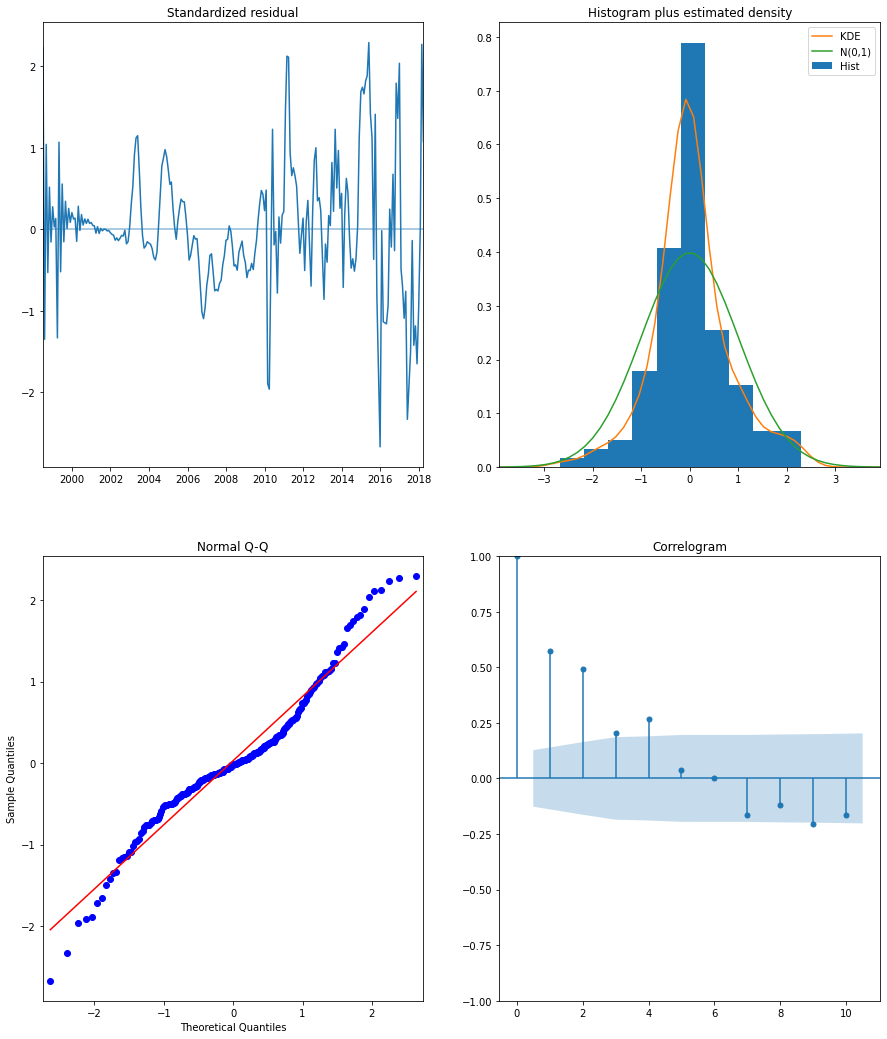

In [53]:
current_zip = 11218
zip_params= output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[current_zip],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

Plot of the real and forecasted values of the time series to assess how well model did.
Also, plot of the confidence intervals overlapping the predicted values.
The forecasts align with the true values and with an overall increase trend.

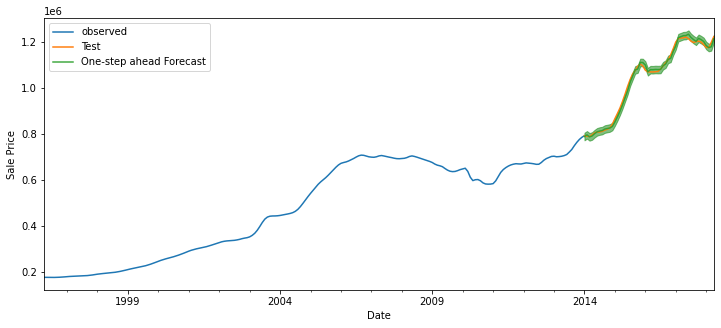

In [54]:
"""

"""
plt.figure(figsize=(12,5))
# Plot observed values
ax = train_brk[11218]['1996':].plot(label='observed')
test_brk[11218]['1996':].plot(label='Test')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [55]:
"""
check for the accuracy of the prediction using RMSE (Mean Squared Error). 
This will provide us with the average error of prediction

Model was able to forecast the average daily real estate sales in the test set within 8,068.75 of the real sales. 
  sales range from around 1,003,700.00 to 2,,202,400.00.     
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test_brk[11218]['1996':]

# Compute the root mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 112518605.71
The Root Mean Squared Error of our forecasts is 10607.48


In [56]:
train_brk[zipcode].describe().round(3)

count        214.000
mean     1319126.636
std       314705.269
min      1003700.000
25%      1037600.000
50%      1167000.000
75%      1567600.000
max      2202400.000
Name: 11217, dtype: float64

In [57]:
zip_params = output_df[output_df['zipcode']==11218]
zip_params

zipcode        pdq   seasonal_pdq          aic
13    11218  (0, 1, 1)  (1, 1, 1, 12)  5290.561381

In [58]:
zip_params['pdq']

13    (0, 1, 1)
Name: pdq, dtype: object

In [59]:
zip_params.pdq.values[0]

(0, 1, 1)

In [60]:
zip_params.seasonal_pdq.values[0]

(1, 1, 1, 12)

We use information from the time series up to a certain point, 
  and after that, forecasts are generated using values from previous forecasted time points.

Calculation for predictions post 2014.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11218   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2444.160
Date:                            Thu, 17 Dec 2020   AIC                           4896.320
Time:                                    20:24:02   BIC                           4910.209
Sample:                                04-01-1996   HQIC                          4901.917
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6674      0.042     15.751      0.000       0.584       0.750
ar.S.L12      -0.3940      0.103     -3.832      0.000      -0.596      -0.192
ma.S.L12      -0.1906      0.081     -2.367      0.018      -0.348      -0.033
sigma2      7.123e+07    1.5e-10   4.76e+17      0.000    7.12e+07    7.12e+07
===================================================================================
Ljung-Box (Q):                      377.37   Jarque-Bera (JB):                21.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+33. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


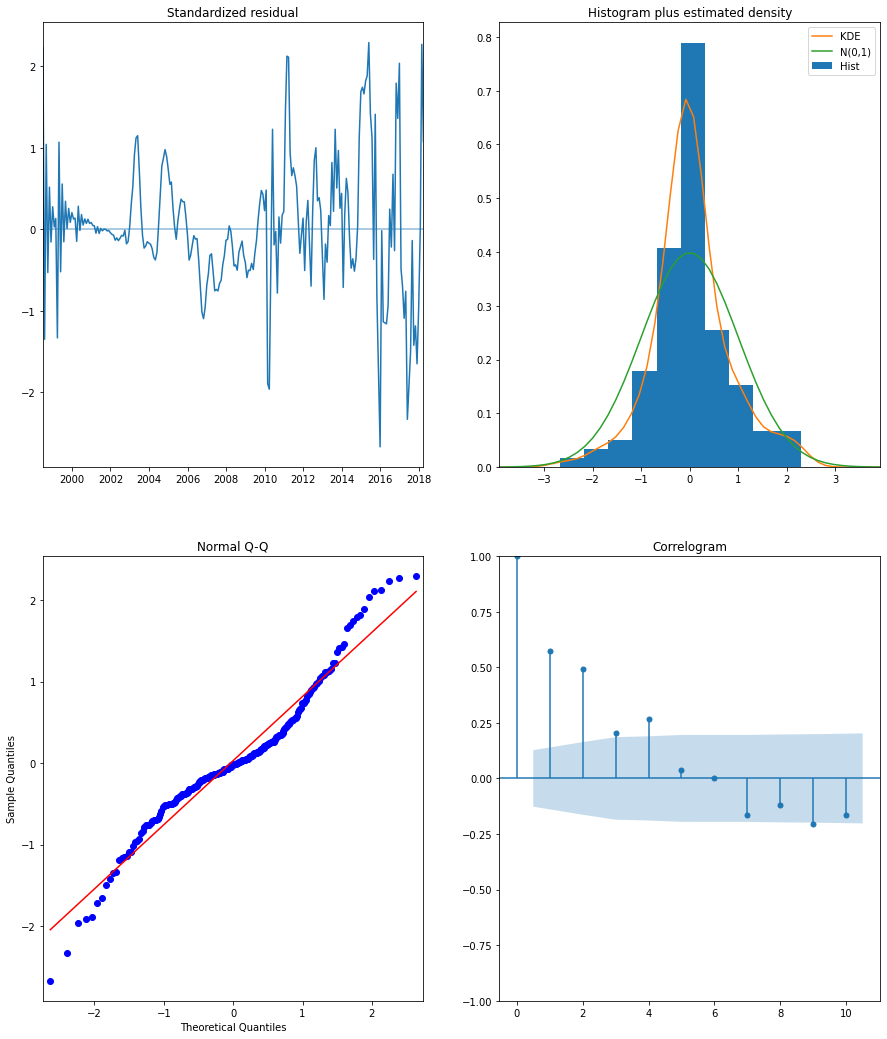

In [61]:
current_zip = 11218
zip_params = output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[current_zip],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. 
All forecasted values (yellow line) match pretty closely to the ground truth (blue line) and are well within the confidence intervals of our forecast.

In [62]:

def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

<AxesSubplot:xlabel='Date', ylabel='Sale Price'>

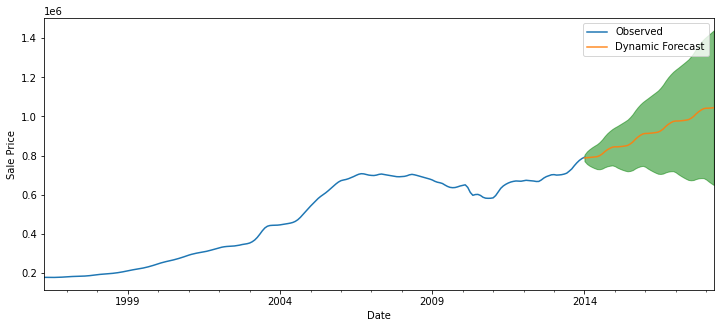

In [63]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train_brk[current_zip])
prediction_visual

In [64]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train_brk[current_zip]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 13869795.96
The Root Mean Squared Error of our forecasts is 3724.22


### **Return on Investment DataFrame**
The method .get_forecast() computes the forecasted values for a specified number of steps ahead.<br>

The method .conf_int() gets the confidence intervals of forecasts.<br>


In [65]:
# Get forecast --- steps ahead in future
prediction = output_sarima.get_forecast(steps=36, dynamic=True)
prediction.predicted_mean

# Get confidence intervals of forecasts
predict_conf = prediction.conf_int()


In [66]:
steps = 36
# Get forecast --- steps ahead in future
prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)

In [67]:
def my_function(prediction_object, zip):
  """
  function gets ROI for 1 zipcode 
  """
  df_Summary = pd.concat([pd.DataFrame({f'Predicted_Mean {zip}':prediction_object.predicted_mean}), prediction_object.conf_int()],axis = 1)
  df_Summary
  # my_sample = df_Summary.iloc[[0, -1]].round(3)
  my_sample = df_Summary.iloc[[0, -1]].round(3) #1st and last

  return my_sample  #df_Summary


In [68]:
my_output = my_function(prediction_object, zip='11218')
my_output

Predicted_Mean 11218  lower 11218  upper 11218
2018-05-01           1231799.938  1215258.766  1248341.109
2021-04-01           1441142.690  1186954.619  1695330.761

In [69]:

def my_roi(cost, current):
  """  
  function to calculate ROI 
  ROI= 
  Cost of Investment
  Current Value of Investment−Cost of Investment
  """
  return (current - cost) / cost


In [70]:
cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]

In [71]:

current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]

In [72]:
#upper lower end
roi_dic = {}

cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]
current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]


my_roi(cost, current)
roi_dic['roi'] = my_roi(cost, current)
roi_dic['roi_lower'] = my_roi(cost, current_lower)
roi_dic['roi_upper'] = my_roi(cost, current_upper)

roi_dic

{'roi': 0.16994866255627286,
 'roi_lower': -0.03640633321739957,
 'roi_upper': 0.37630365832994533}

In [73]:
my_output

Predicted_Mean 11218  lower 11218  upper 11218
2018-05-01           1231799.938  1215258.766  1248341.109
2021-04-01           1441142.690  1186954.619  1695330.761

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11226   No. Observations:                  265
Model:             SARIMAX(2, 0, 0)x(2, 1, 1, 12)   Log Likelihood               -2258.133
Date:                            Thu, 17 Dec 2020   AIC                           4528.266
Time:                                    20:24:12   BIC                           4548.815
Sample:                                04-01-1996   HQIC                          4536.558
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8035      0.052     34.738      0.000       1.702       1.905
ar.L2         -0.8041      0.053    -15.232      0.000      -0.908      -0.701
ar.S.L12      -0.8367      0.109     -7.707      0.000      -1.049      -0.624
ar.S.L24      -0.4481      0.126     -3.552      0.000      -0.695      -0.201
ma.S.L12      -0.0706      0.080     -0.883      0.377      -0.227       0.086
sigma2       3.56e+07   7.49e-10   4.75e+16      0.000    3.56e+07    3.56e+07
===================================================================================
Ljung-Box (Q):                      177.41   Jarque-Bera (JB):               150.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              21.44   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.14e+32. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


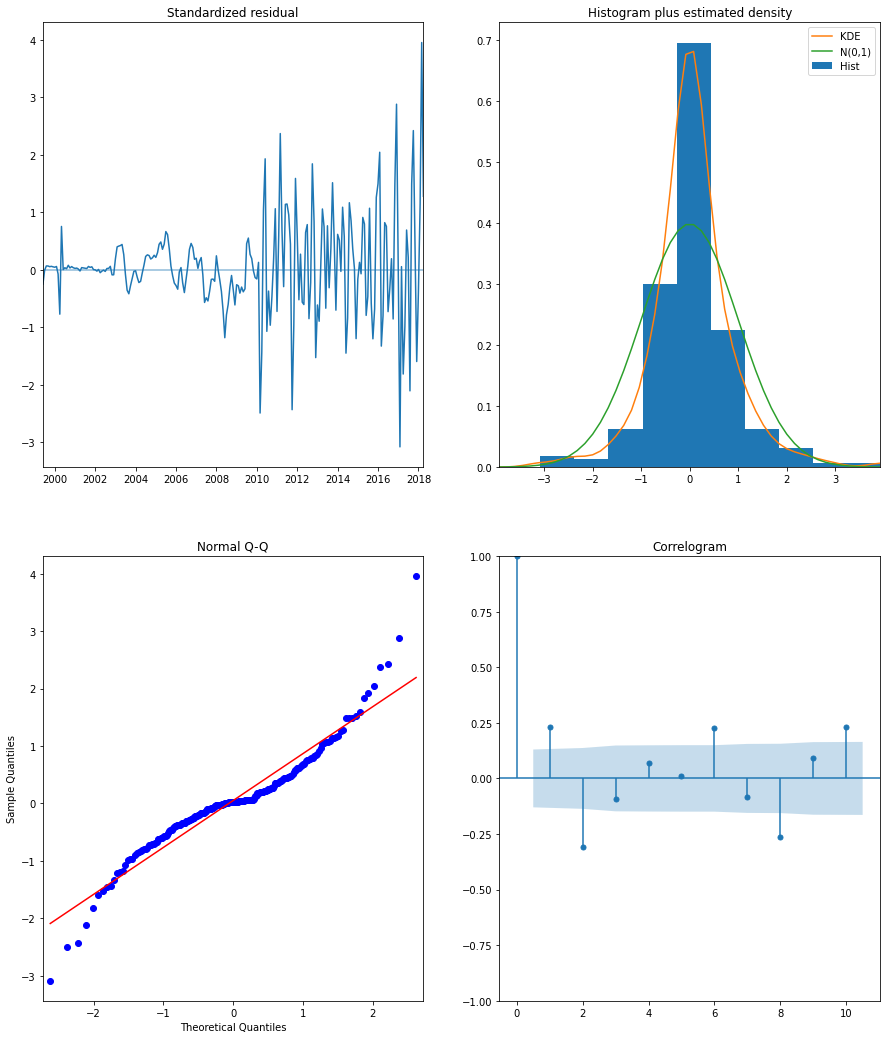

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11235   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2193.358
Date:                            Thu, 17 Dec 2020   AIC                           4394.715
Time:                                    20:24:15   BIC                           4408.621
Sample:                                04-01-1996   HQIC                          4400.319
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8416      0.031     27.148      0.000       0.781       0.902
ar.S.L12      -0.4782      0.069     -6.912      0.000      -0.614      -0.343
ma.S.L12      -0.0372      0.043     -0.862      0.389      -0.122       0.047
sigma2      5.471e+06   3.34e+05     16.361      0.000    4.82e+06    6.13e+06
===================================================================================
Ljung-Box (Q):                      187.79   Jarque-Bera (JB):                78.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.36   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


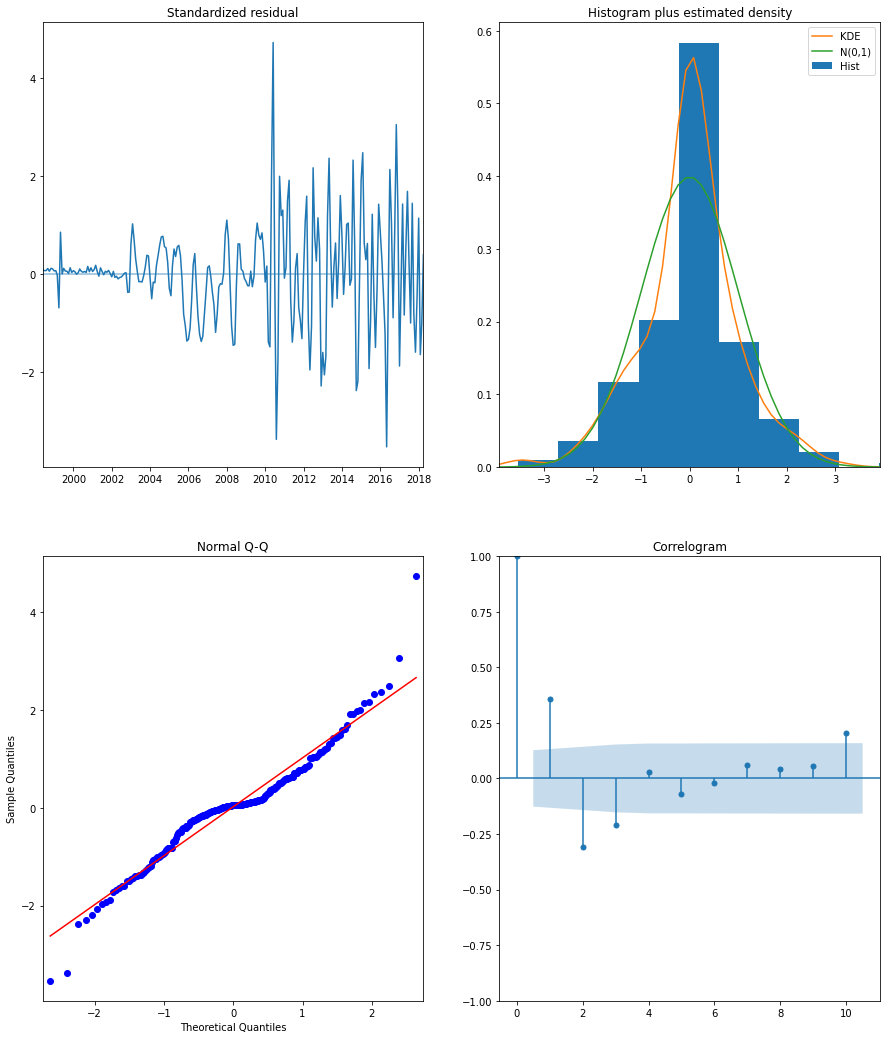

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11230   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood               -2160.080
Date:                            Thu, 17 Dec 2020   AIC                           4330.159
Time:                                    20:24:17   BIC                           4347.284
Sample:                                04-01-1996   HQIC                          4337.069
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8902      0.043     20.802      0.000       0.806       0.974
ar.S.L12      -0.6404      0.124     -5.179      0.000      -0.883      -0.398
ar.S.L24      -0.2941      0.092     -3.193      0.001      -0.475      -0.114
ma.S.L12      -0.0660      0.082     -0.805      0.421      -0.227       0.095
sigma2      1.367e+07   1.16e+06     11.786      0.000    1.14e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      148.45   Jarque-Bera (JB):                60.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.31   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


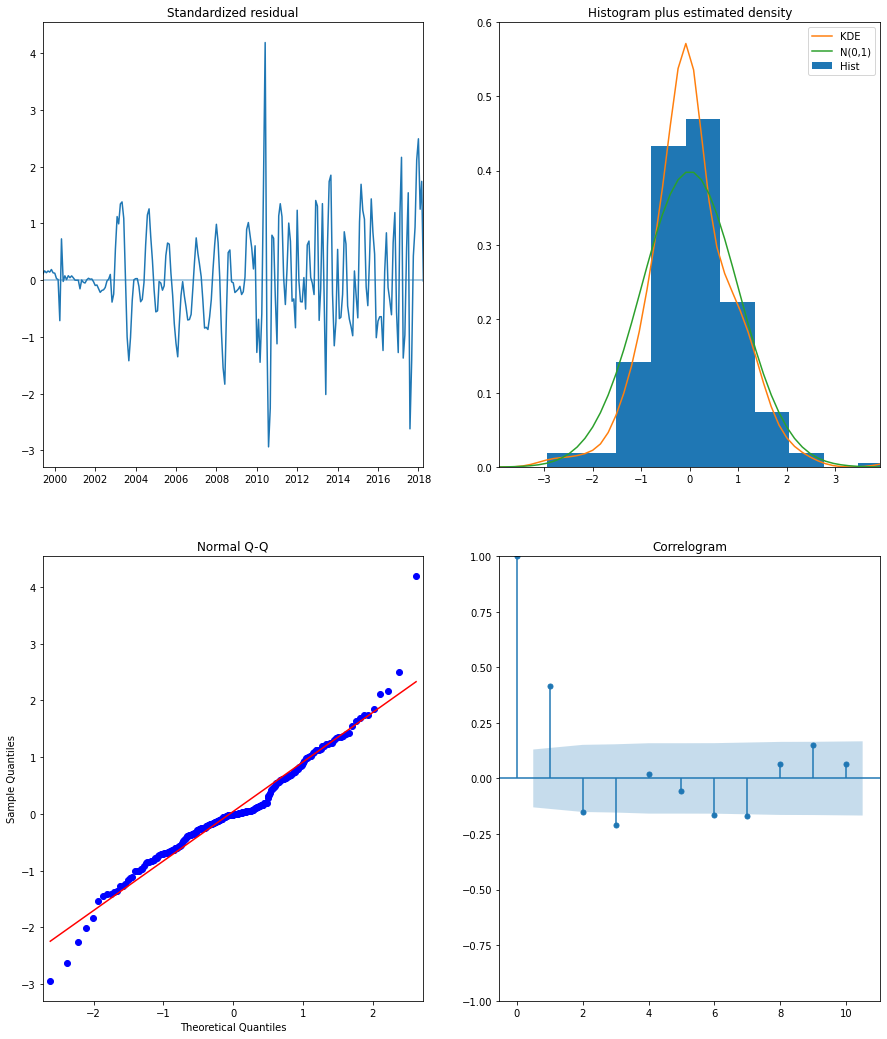

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11209   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -2216.342
Date:                            Thu, 17 Dec 2020   AIC                           4444.683
Time:                                    20:24:22   BIC                           4465.207
Sample:                                04-01-1996   HQIC                          4452.966
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0439      0.018     57.746      0.000       1.008       1.079
ar.S.L12       0.0811      0.164      0.495      0.620      -0.240       0.402
ar.S.L24      -0.0575      0.107     -0.536      0.592      -0.268       0.153
ma.S.L12      -0.6260      0.182     -3.444      0.001      -0.982      -0.270
ma.S.L24       0.1605      0.148      1.083      0.279      -0.130       0.451
sigma2      2.482e+07   2.03e-09   1.22e+16      0.000    2.48e+07    2.48e+07
===================================================================================
Ljung-Box (Q):                      209.78   Jarque-Bera (JB):                 4.80
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               5.34   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+32. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


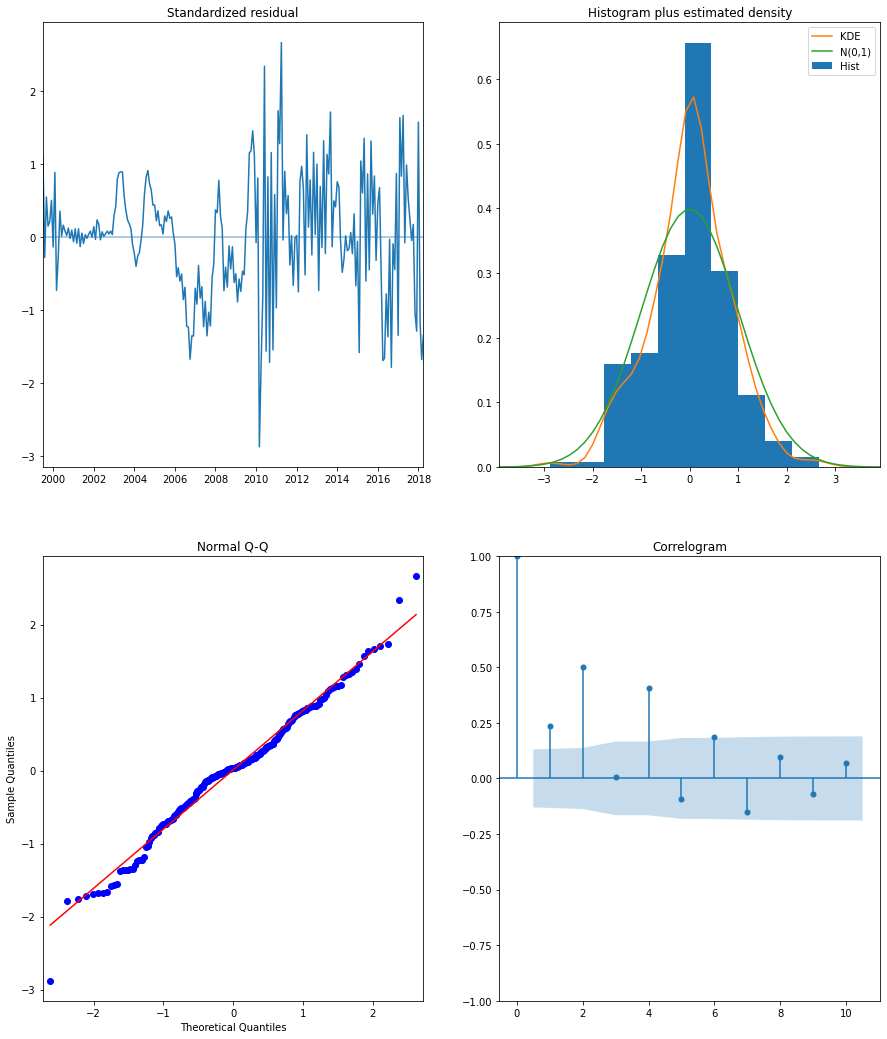

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11212   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1869.543
Date:                            Thu, 17 Dec 2020   AIC                           3751.087
Time:                                    20:24:27   BIC                           3771.583
Sample:                                04-01-1996   HQIC                          3759.359
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7565      0.064     27.391      0.000       1.631       1.882
ar.L2         -1.2217      0.107    -11.427      0.000      -1.431      -1.012
ar.L3          0.3916      0.056      7.002      0.000       0.282       0.501
ar.S.L12      -0.7358      0.062    -11.955      0.000      -0.856      -0.615
ar.S.L24      -0.4012      0.054     -7.452      0.000      -0.507      -0.296
sigma2      9.654e+05   6.64e+04     14.541      0.000    8.35e+05     1.1e+06
===================================================================================
Ljung-Box (Q):                      117.47   Jarque-Bera (JB):               134.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.51   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


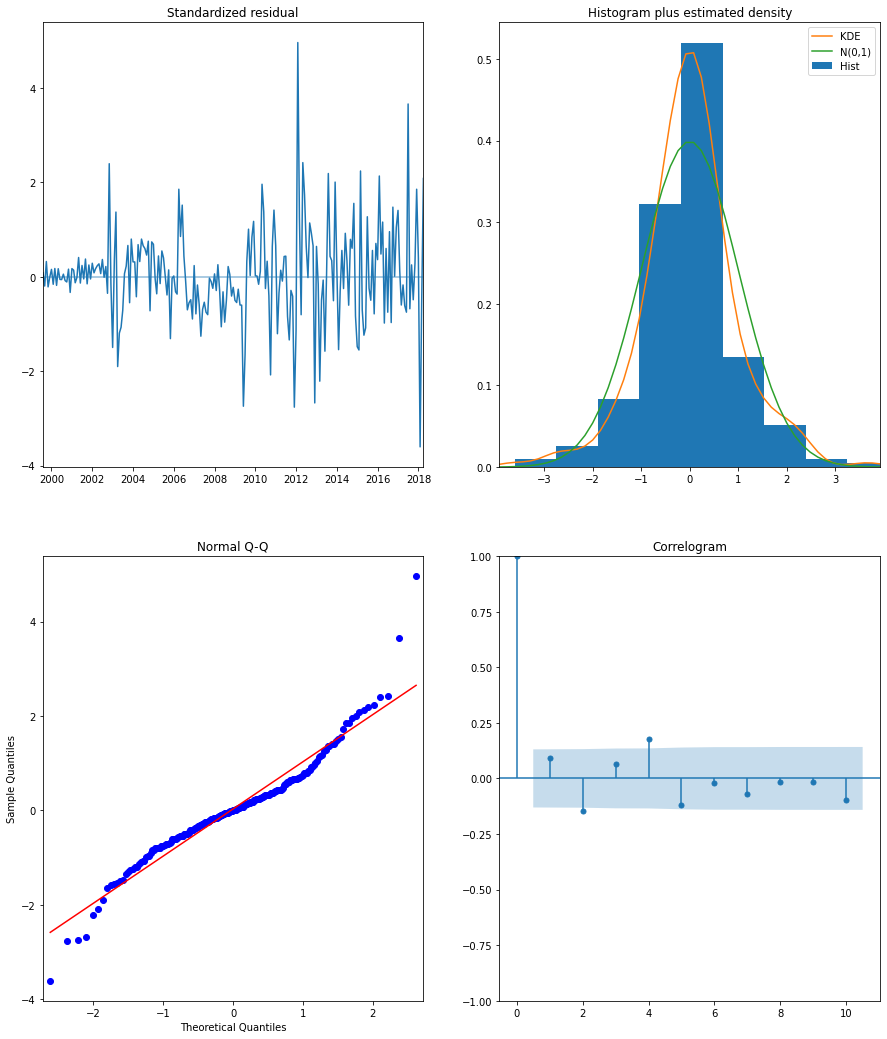

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11214   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 2, 12)   Log Likelihood               -2101.883
Date:                            Thu, 17 Dec 2020   AIC                           4215.765
Time:                                    20:24:30   BIC                           4236.315
Sample:                                04-01-1996   HQIC                          4224.057
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8579      0.047     18.232      0.000       0.766       0.950
ar.S.L12      -0.8886      0.334     -2.660      0.008      -1.543      -0.234
ar.S.L24      -0.4026      0.159     -2.528      0.011      -0.715      -0.090
ma.S.L12      -0.0026      0.315     -0.008      0.993      -0.620       0.614
ma.S.L24      -0.0136      0.186     -0.073      0.942      -0.378       0.351
sigma2      9.689e+06   9.51e+05     10.194      0.000    7.83e+06    1.16e+07
===================================================================================
Ljung-Box (Q):                      158.95   Jarque-Bera (JB):               153.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              31.08   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


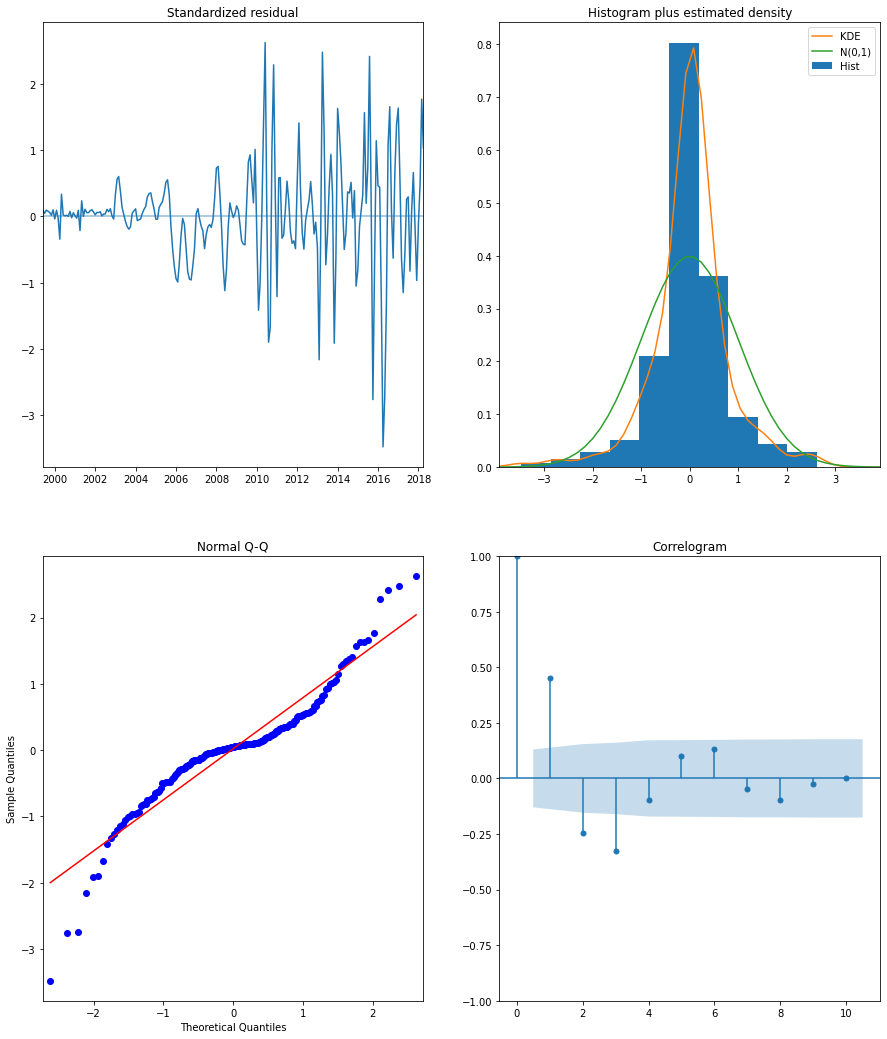

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11221   No. Observations:                  265
Model:             SARIMAX(2, 2, 2)x(1, 1, 1, 12)   Log Likelihood               -2205.692
Date:                            Thu, 17 Dec 2020   AIC                           4425.383
Time:                                    20:24:34   BIC                           4449.630
Sample:                                04-01-1996   HQIC                          4435.157
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1386      0.142      0.974      0.330      -0.140       0.417
ar.L2         -0.5222      0.072     -7.301      0.000      -0.662      -0.382
ma.L1          0.3922      0.148      2.656      0.008       0.103       0.682
ma.L2          0.0631      0.092      0.685      0.494      -0.118       0.244
ar.S.L12      -0.7633      0.085     -9.023      0.000      -0.929      -0.597
ma.S.L12      -0.0126      0.092     -0.136      0.892      -0.194       0.169
sigma2      1.005e+07      7e+05     14.351      0.000    8.68e+06    1.14e+07
===================================================================================
Ljung-Box (Q):                       83.81   Jarque-Bera (JB):               659.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              28.69   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.84e+14. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


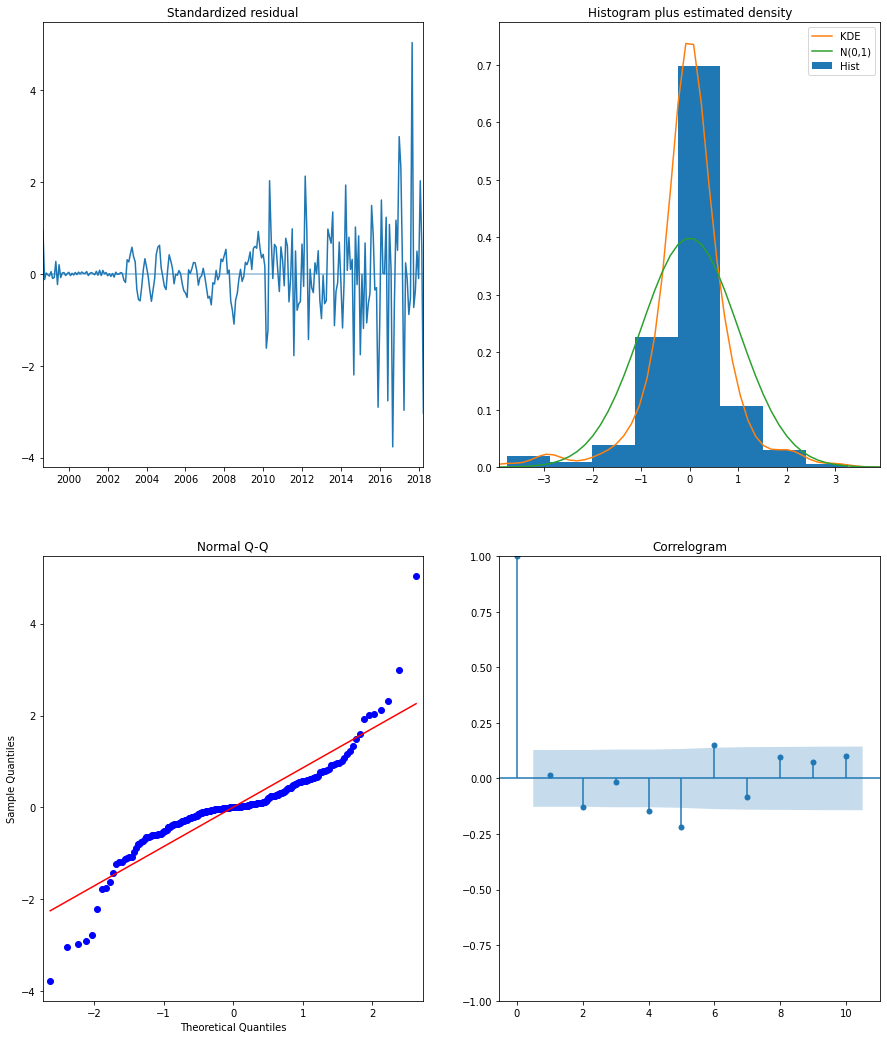

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11229   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1975.562
Date:                            Thu, 17 Dec 2020   AIC                           3961.125
Time:                                    20:24:39   BIC                           3978.227
Sample:                                04-01-1996   HQIC                          3968.027
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3062      0.036     35.927      0.000       1.235       1.377
ar.L2         -0.4577      0.037    -12.445      0.000      -0.530      -0.386
ar.S.L12      -0.7020      0.056    -12.559      0.000      -0.812      -0.592
ar.S.L24      -0.4326      0.065     -6.652      0.000      -0.560      -0.305
sigma2      2.292e+06   1.58e+05     14.515      0.000    1.98e+06     2.6e+06
===================================================================================
Ljung-Box (Q):                      139.66   Jarque-Bera (JB):                89.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.56   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


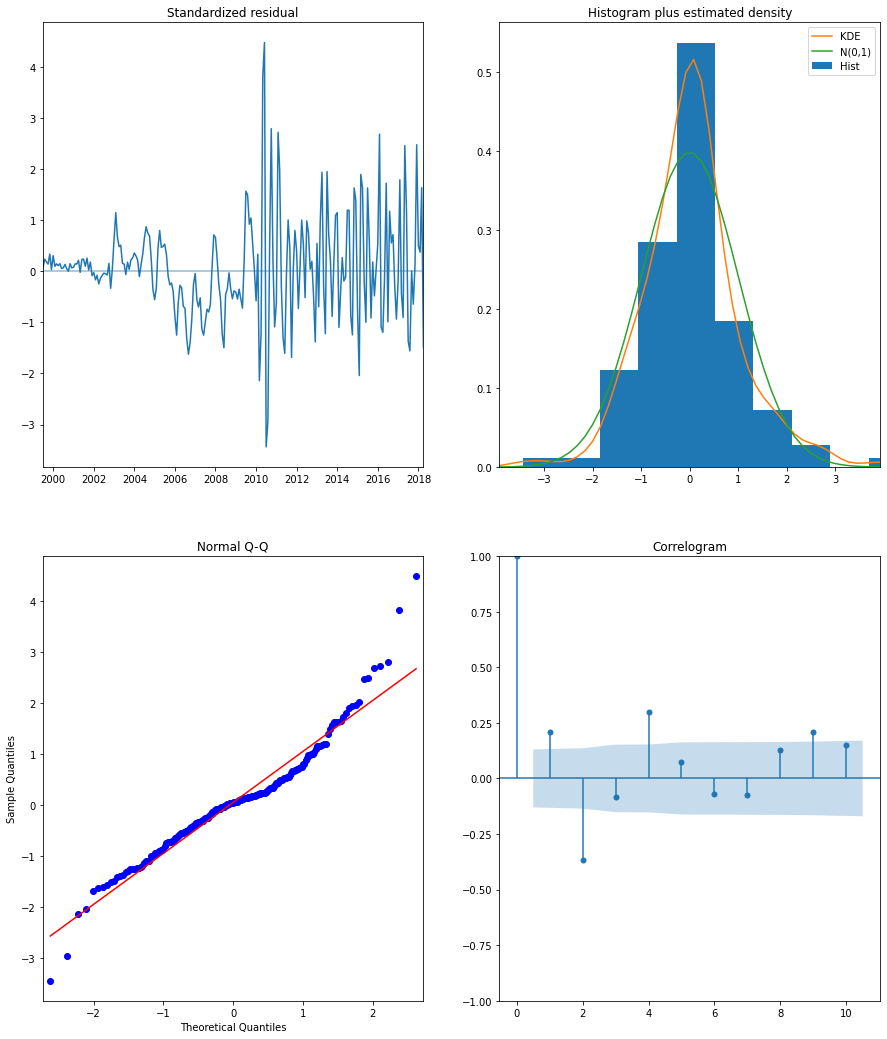

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11234   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1975.003
Date:                            Thu, 17 Dec 2020   AIC                           3960.005
Time:                                    20:24:42   BIC                           3977.108
Sample:                                04-01-1996   HQIC                          3966.907
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2331      0.048     25.756      0.000       1.139       1.327
ar.L2         -0.4501      0.055     -8.235      0.000      -0.557      -0.343
ar.S.L12      -0.6156      0.075     -8.259      0.000      -0.762      -0.470
ar.S.L24      -0.3202      0.065     -4.904      0.000      -0.448      -0.192
sigma2      2.706e+06   2.35e+05     11.518      0.000    2.25e+06    3.17e+06
===================================================================================
Ljung-Box (Q):                      200.17   Jarque-Bera (JB):               100.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.99   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


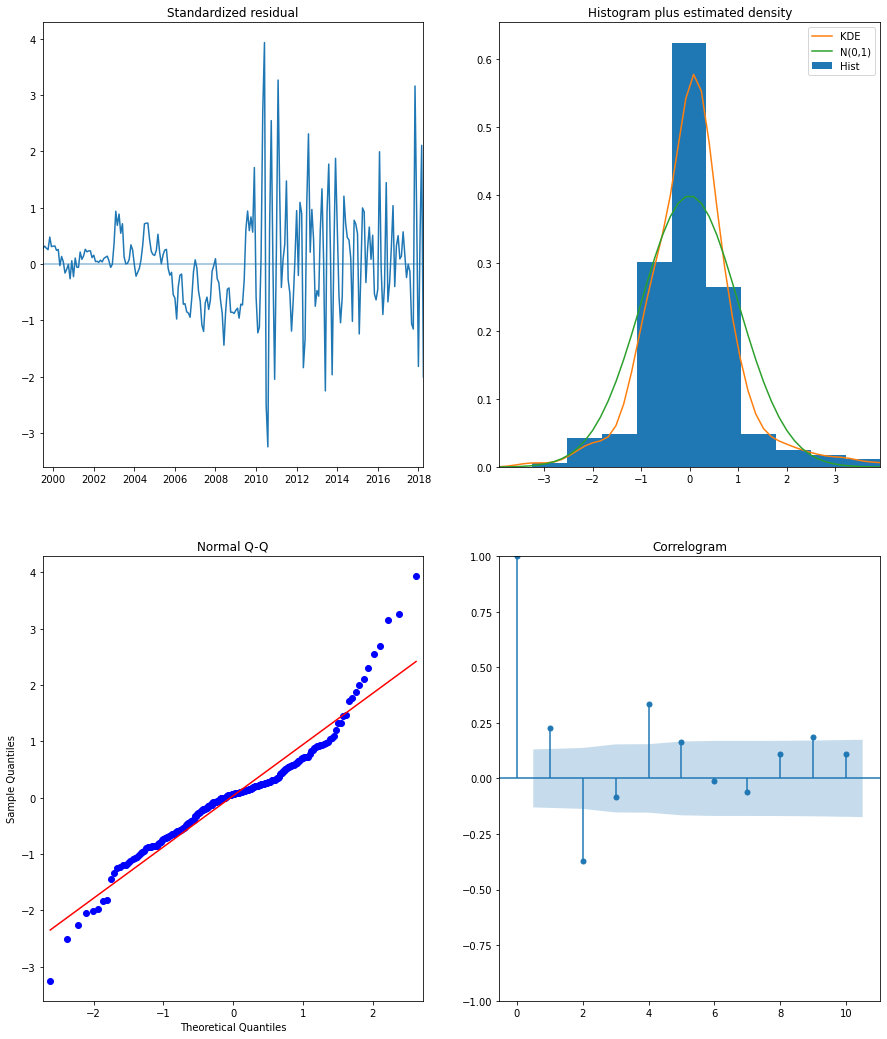

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11215   No. Observations:                  265
Model:             SARIMAX(3, 0, 0)x(0, 1, 2, 12)   Log Likelihood               -2816.046
Date:                            Thu, 17 Dec 2020   AIC                           5644.092
Time:                                    20:24:47   BIC                           5664.668
Sample:                                04-01-1996   HQIC                          5652.394
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2050      0.042     53.045      0.000       2.124       2.287
ar.L2         -1.7726      0.082    -21.524      0.000      -1.934      -1.611
ar.L3          0.5280      0.049     10.885      0.000       0.433       0.623
ma.S.L12       8.6627      0.200     43.215      0.000       8.270       9.056
ma.S.L24       4.2611      1.487      2.866      0.004       1.347       7.175
sigma2      7.421e+07   7.21e-08   1.03e+15      0.000    7.42e+07    7.42e+07
===================================================================================
Ljung-Box (Q):                      156.26   Jarque-Bera (JB):             14236.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             4.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.28e+30. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


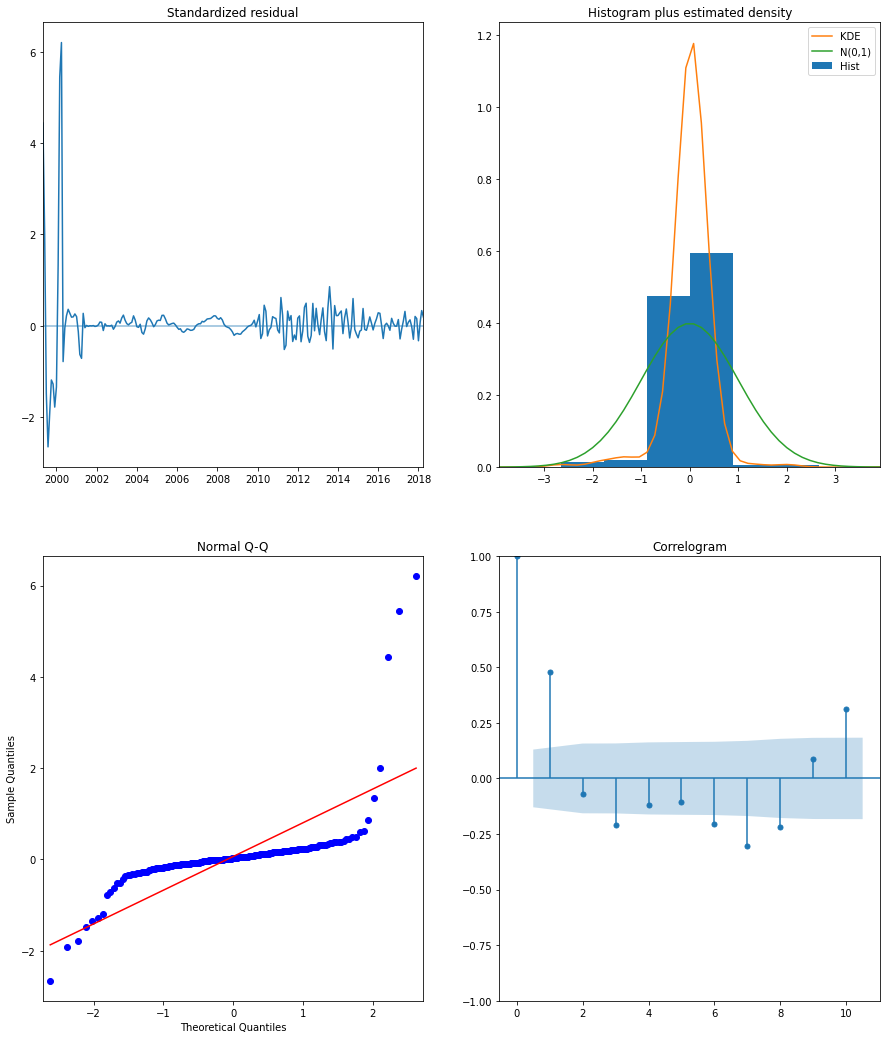

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11211   No. Observations:                  265
Model:             SARIMAX(2, 0, 1)x(2, 1, 0, 12)   Log Likelihood               -2342.400
Date:                            Thu, 17 Dec 2020   AIC                           4696.800
Time:                                    20:24:53   BIC                           4717.349
Sample:                                04-01-1996   HQIC                          4705.092
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5520      0.086     17.976      0.000       1.383       1.721
ar.L2         -0.5515      0.087     -6.338      0.000      -0.722      -0.381
ma.L1          0.5140      0.076      6.727      0.000       0.364       0.664
ar.S.L12      -0.9085      0.077    -11.800      0.000      -1.059      -0.758
ar.S.L24      -0.3268      0.063     -5.188      0.000      -0.450      -0.203
sigma2      8.057e+07   4.01e-10   2.01e+17      0.000    8.06e+07    8.06e+07
===================================================================================
Ljung-Box (Q):                       75.74   Jarque-Bera (JB):                39.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.55   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+35. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


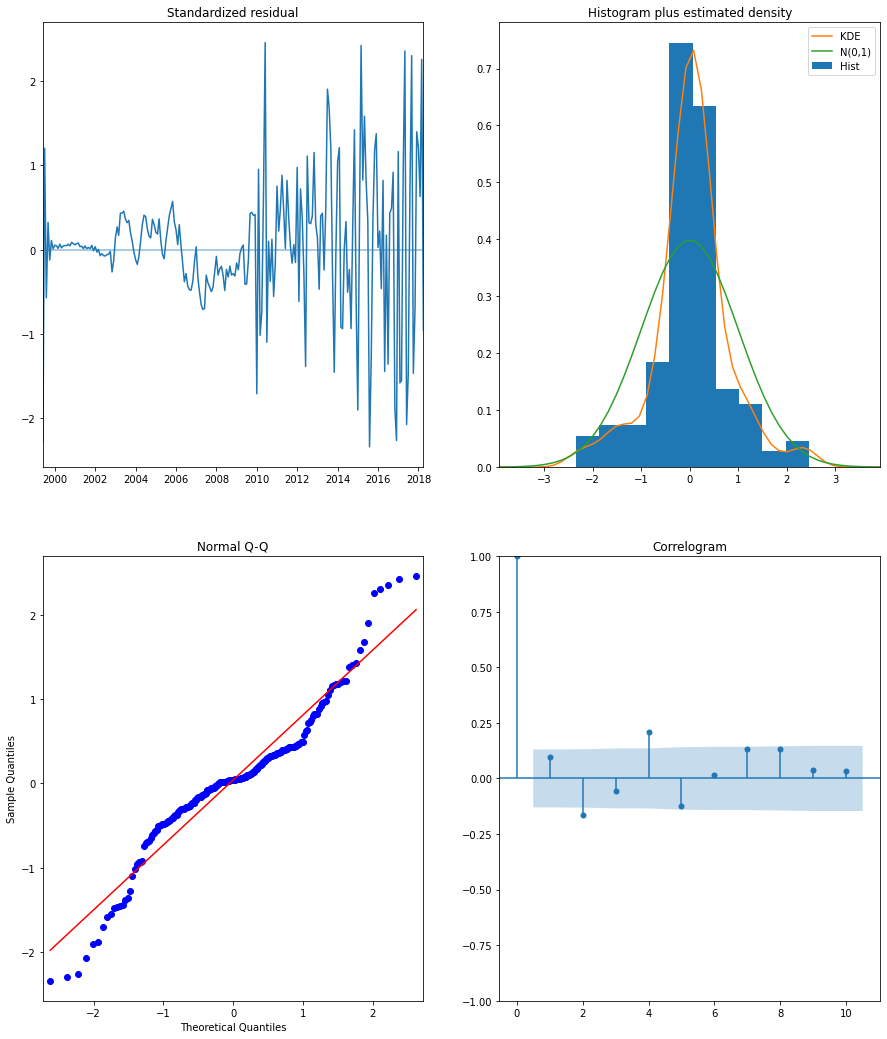

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11233   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2299.125
Date:                            Thu, 17 Dec 2020   AIC                           4606.250
Time:                                    20:24:55   BIC                           4620.156
Sample:                                04-01-1996   HQIC                          4611.854
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8020      0.039     20.561      0.000       0.726       0.878
ar.S.L12      -0.6376      0.075     -8.514      0.000      -0.784      -0.491
ma.S.L12      -0.0592      0.075     -0.790      0.429      -0.206       0.088
sigma2      1.724e+07   8.23e-10    2.1e+16      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (Q):                      151.87   Jarque-Bera (JB):               272.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              42.42   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.2e+30. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


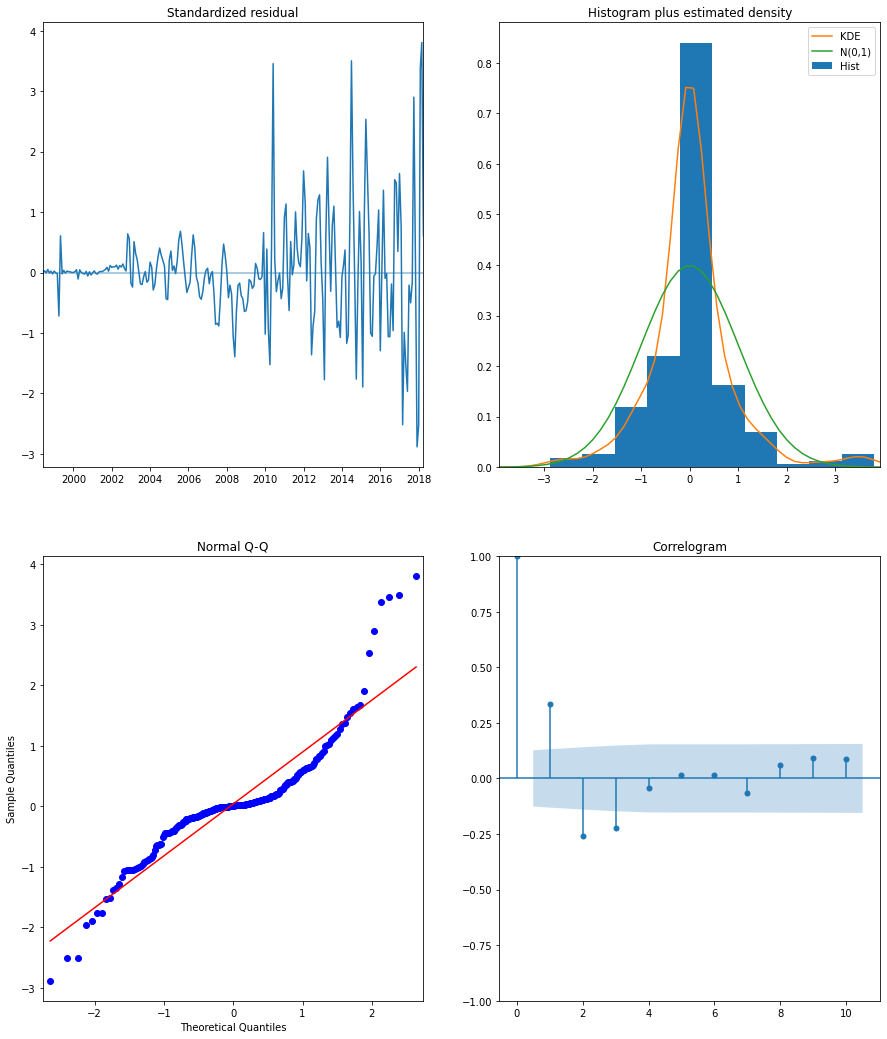

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11236   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood               -2010.581
Date:                            Thu, 17 Dec 2020   AIC                           4031.162
Time:                                    20:24:58   BIC                           4048.287
Sample:                                04-01-1996   HQIC                          4038.072
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8880      0.040     22.410      0.000       0.810       0.966
ar.S.L12      -0.6342      0.113     -5.612      0.000      -0.856      -0.413
ar.S.L24      -0.3009      0.102     -2.964      0.003      -0.500      -0.102
ma.S.L12      -0.0498      0.085     -0.587      0.557      -0.216       0.116
sigma2      3.686e+06   3.85e+05      9.581      0.000    2.93e+06    4.44e+06
===================================================================================
Ljung-Box (Q):                      139.58   Jarque-Bera (JB):                 8.30
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               8.69   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


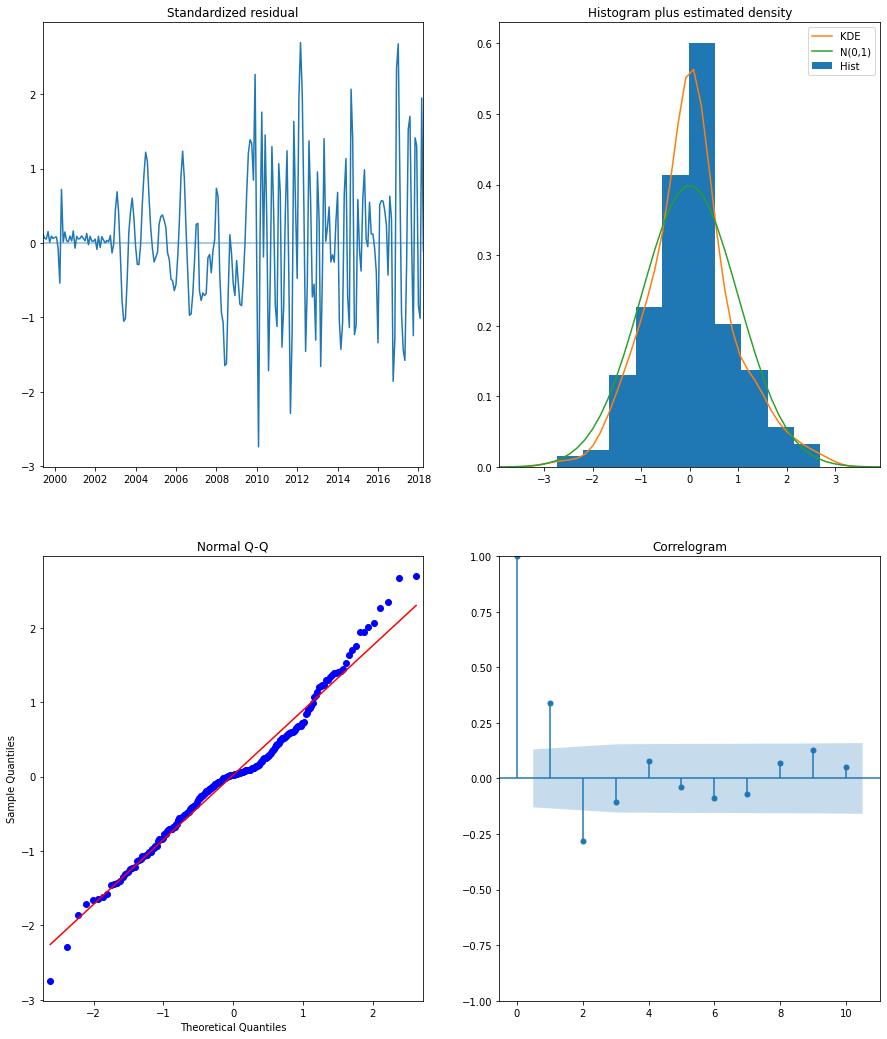

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11218   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2444.160
Date:                            Thu, 17 Dec 2020   AIC                           4896.320
Time:                                    20:25:01   BIC                           4910.209
Sample:                                04-01-1996   HQIC                          4901.917
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6674      0.042     15.751      0.000       0.584       0.750
ar.S.L12      -0.3940      0.103     -3.832      0.000      -0.596      -0.192
ma.S.L12      -0.1906      0.081     -2.367      0.018      -0.348      -0.033
sigma2      7.123e+07    1.5e-10   4.76e+17      0.000    7.12e+07    7.12e+07
===================================================================================
Ljung-Box (Q):                      377.37   Jarque-Bera (JB):                21.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+33. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


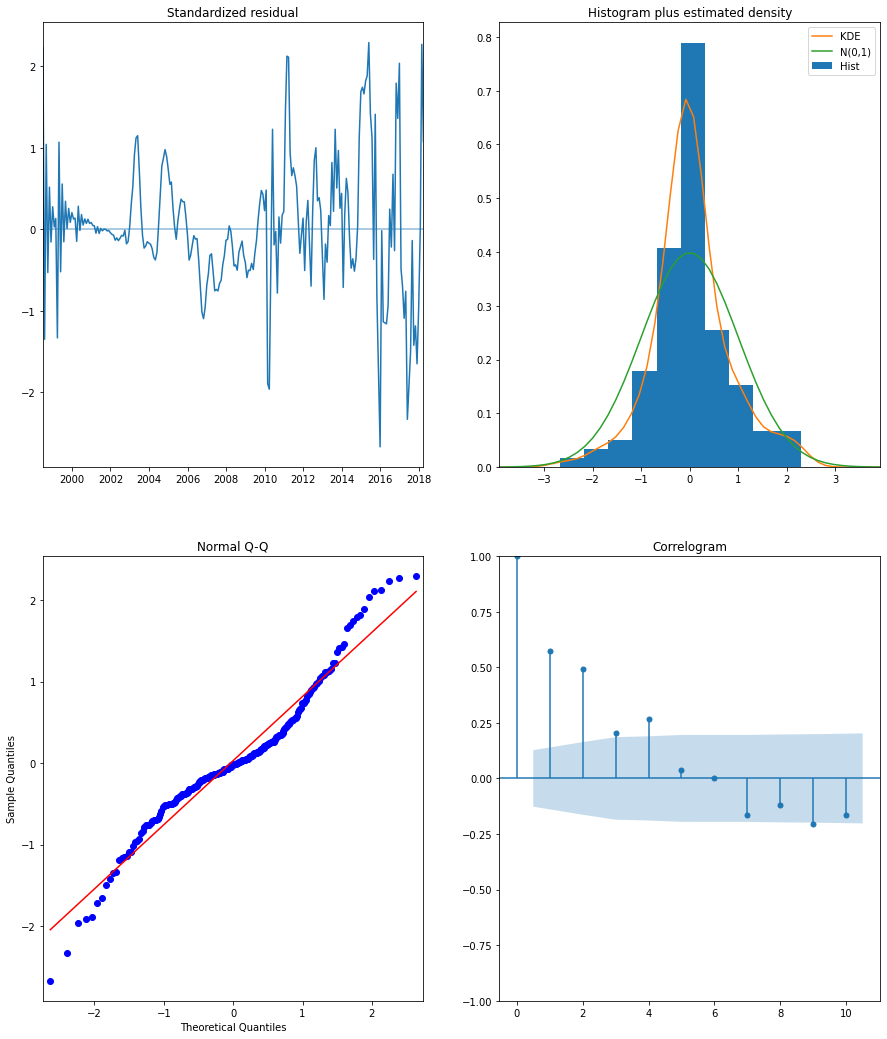

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11223   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2279.363
Date:                            Thu, 17 Dec 2020   AIC                           4566.726
Time:                                    20:25:04   BIC                           4580.631
Sample:                                04-01-1996   HQIC                          4572.329
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8934      0.036     24.712      0.000       0.823       0.964
ar.S.L12      -0.5475      0.067     -8.229      0.000      -0.678      -0.417
ma.S.L12      -0.0577      0.037     -1.564      0.118      -0.130       0.015
sigma2      1.451e+07   8.46e+05     17.158      0.000    1.29e+07    1.62e+07
===================================================================================
Ljung-Box (Q):                      222.98   Jarque-Bera (JB):               511.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.97   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


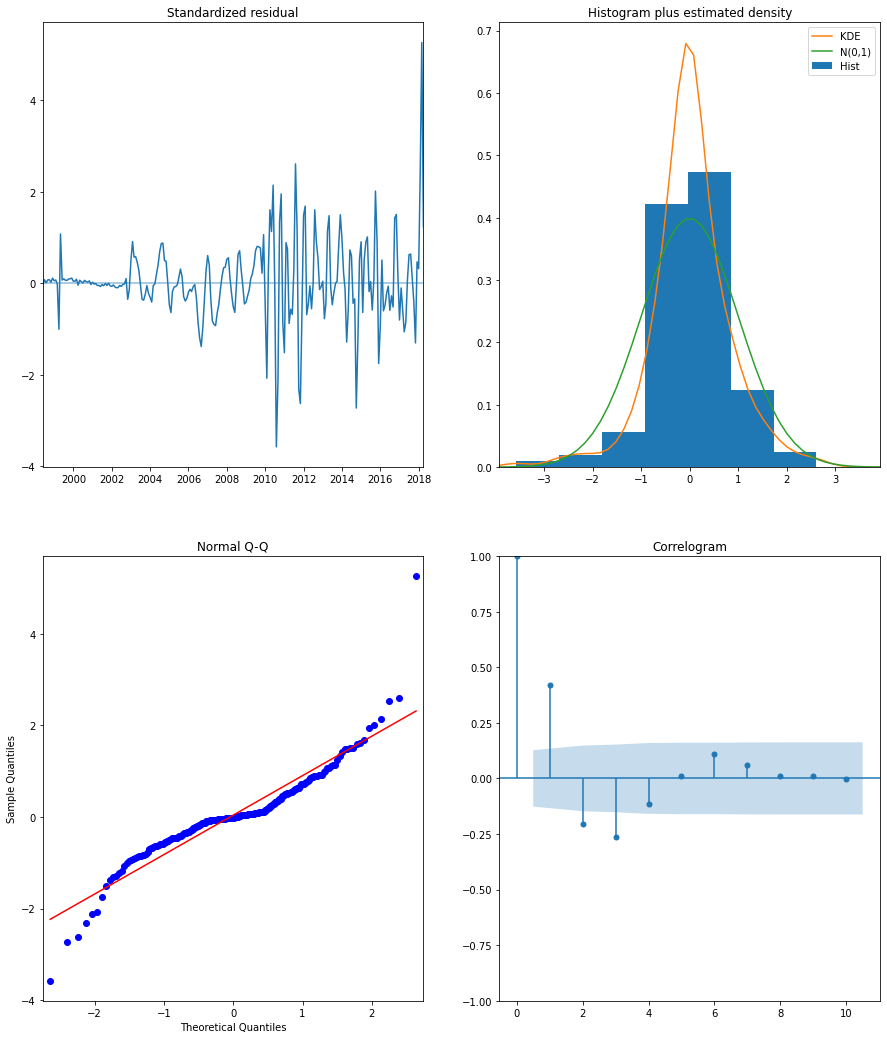

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11208   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(2, 1, 1, 12)   Log Likelihood               -2244.144
Date:                            Thu, 17 Dec 2020   AIC                           4498.287
Time:                                    20:25:10   BIC                           4515.434
Sample:                                04-01-1996   HQIC                          4505.206
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0014      0.008    124.185      0.000       0.986       1.017
ar.S.L12      -0.6327      0.192     -3.299      0.001      -1.009      -0.257
ar.S.L24      -0.4040      0.150     -2.691      0.007      -0.698      -0.110
ma.S.L12      -0.0361      0.204     -0.177      0.859      -0.435       0.363
sigma2      2.667e+07   1.48e-09    1.8e+16      0.000    2.67e+07    2.67e+07
===================================================================================
Ljung-Box (Q):                      425.57   Jarque-Bera (JB):                 8.20
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               5.07   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+34. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


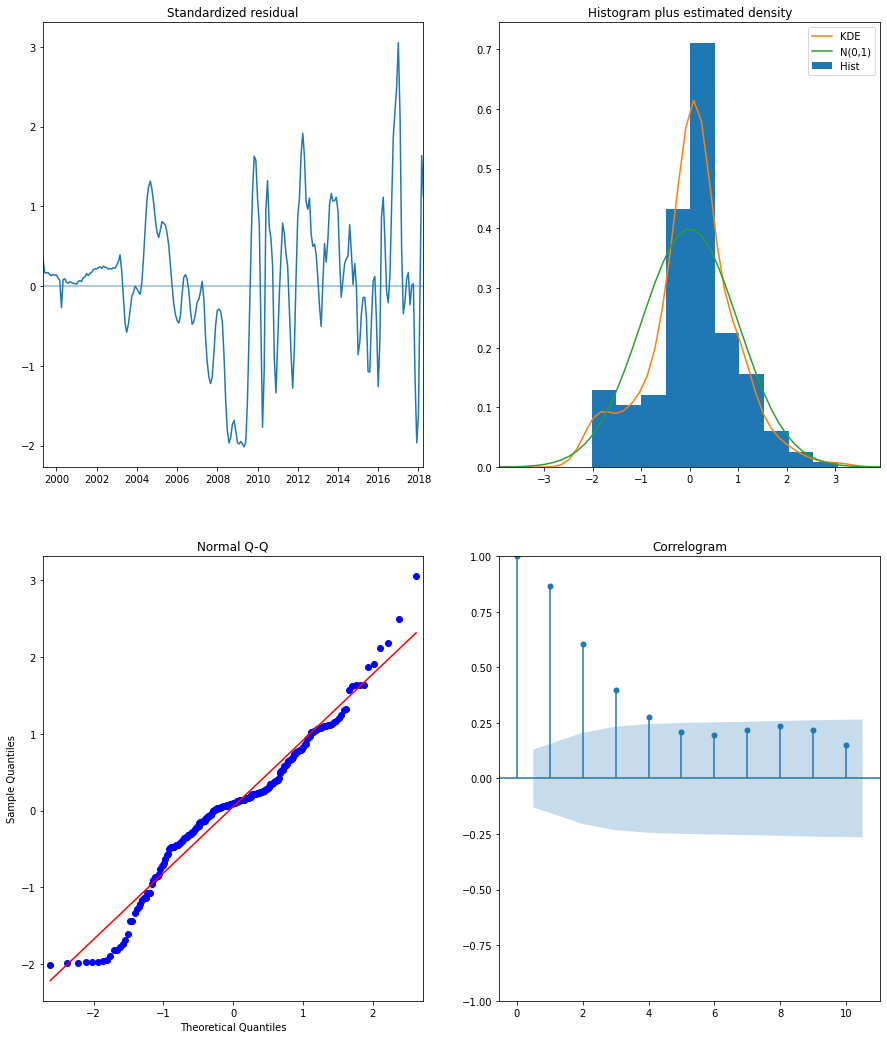

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11204   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2181.111
Date:                            Thu, 17 Dec 2020   AIC                           4370.223
Time:                                    20:25:12   BIC                           4384.129
Sample:                                04-01-1996   HQIC                          4375.827
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8589      0.048     17.892      0.000       0.765       0.953
ar.S.L12      -0.5474      0.060     -9.184      0.000      -0.664      -0.431
ma.S.L12      -0.0368      0.035     -1.055      0.292      -0.105       0.032
sigma2      6.516e+06    5.3e+05     12.305      0.000    5.48e+06    7.55e+06
===================================================================================
Ljung-Box (Q):                      195.58   Jarque-Bera (JB):               103.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.67   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


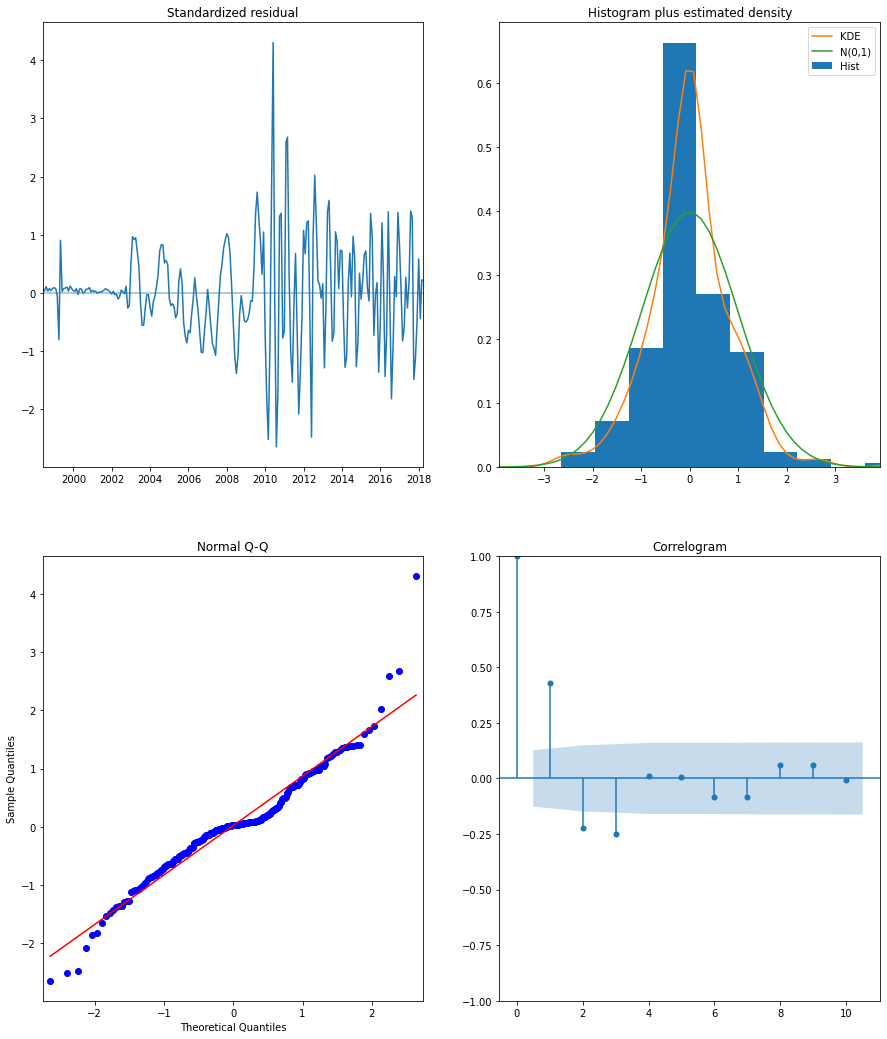

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11219   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(0, 1, 2, 12)   Log Likelihood               -2199.865
Date:                            Thu, 17 Dec 2020   AIC                           4409.730
Time:                                    20:25:20   BIC                           4426.855
Sample:                                04-01-1996   HQIC                          4416.640
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2281      0.035     34.718      0.000       1.159       1.297
ar.L2         -0.4825      0.037    -12.990      0.000      -0.555      -0.410
ma.S.L12      -5.6869      2.195     -2.591      0.010      -9.989      -1.385
ma.S.L24       1.8844      1.062      1.774      0.076      -0.198       3.966
sigma2      5.277e+05   4.23e+05      1.248      0.212   -3.01e+05    1.36e+06
===================================================================================
Ljung-Box (Q):                       87.41   Jarque-Bera (JB):               180.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.20   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


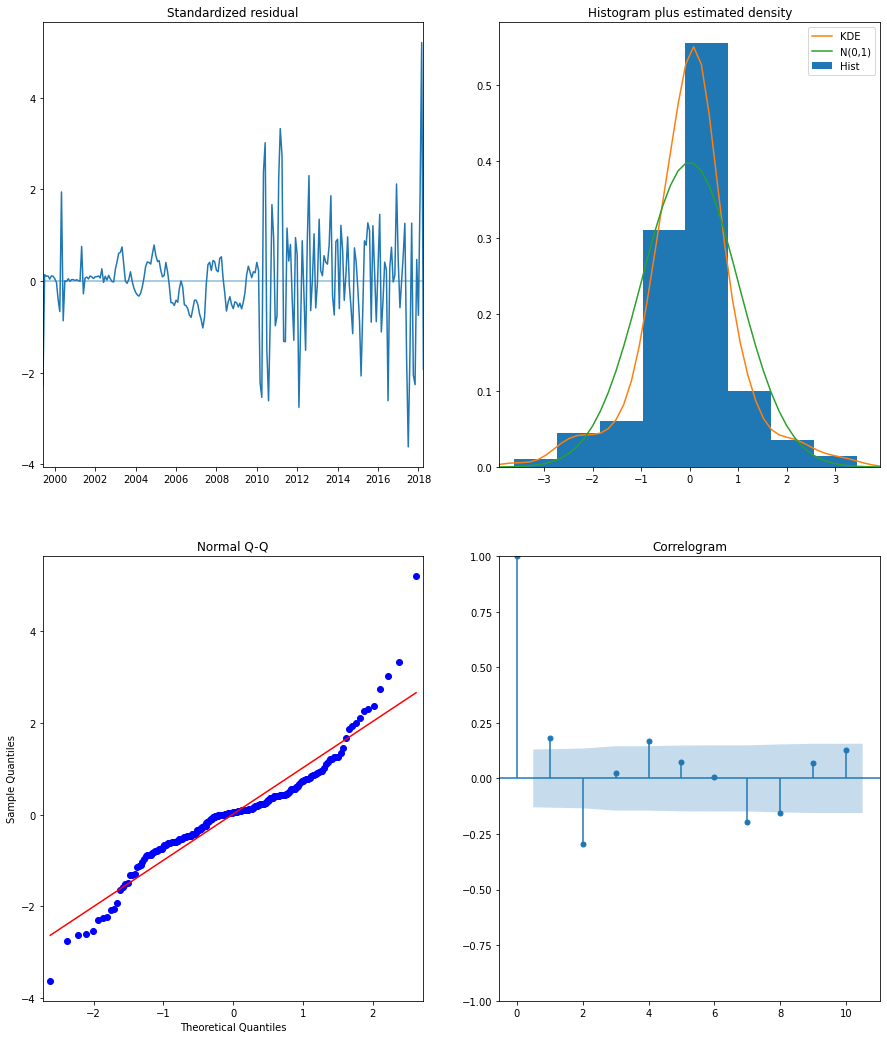

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11203   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1946.226
Date:                            Thu, 17 Dec 2020   AIC                           3904.452
Time:                                    20:25:25   BIC                           3924.949
Sample:                                04-01-1996   HQIC                          3912.725
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3821      0.042     32.664      0.000       1.299       1.465
ar.L2         -0.8883      0.054    -16.367      0.000      -0.995      -0.782
ar.L3          0.4154      0.041     10.091      0.000       0.335       0.496
ar.S.L12      -0.7552      0.073    -10.354      0.000      -0.898      -0.612
ar.S.L24      -0.4179      0.063     -6.632      0.000      -0.541      -0.294
sigma2      1.909e+06   1.25e+05     15.275      0.000    1.66e+06    2.15e+06
===================================================================================
Ljung-Box (Q):                       93.09   Jarque-Bera (JB):                93.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.46   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


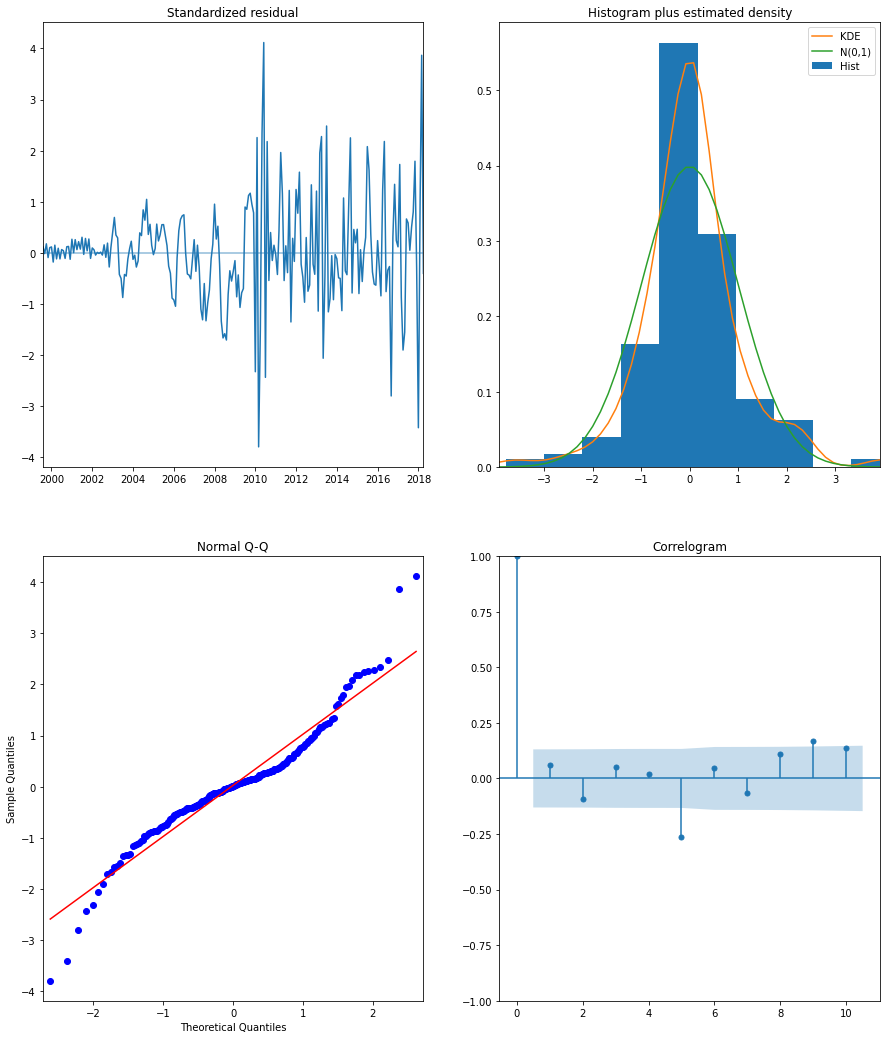

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11220   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(2, 1, 1, 12)   Log Likelihood               -2662.018
Date:                            Thu, 17 Dec 2020   AIC                           5334.036
Time:                                    20:25:28   BIC                           5351.183
Sample:                                04-01-1996   HQIC                          5340.954
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0285      0.009    117.695      0.000       1.011       1.046
ar.S.L12      -1.1694      0.284     -4.115      0.000      -1.726      -0.612
ar.S.L24       0.1543      1.049      0.147      0.883      -1.902       2.210
ma.S.L12       4.8211      0.147     32.846      0.000       4.533       5.109
sigma2      5.131e+07   1.34e-08   3.82e+15      0.000    5.13e+07    5.13e+07
===================================================================================
Ljung-Box (Q):                       60.65   Jarque-Bera (JB):            165683.50
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -9.91
Prob(H) (two-sided):                  0.00   Kurtosis:                       133.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+31. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


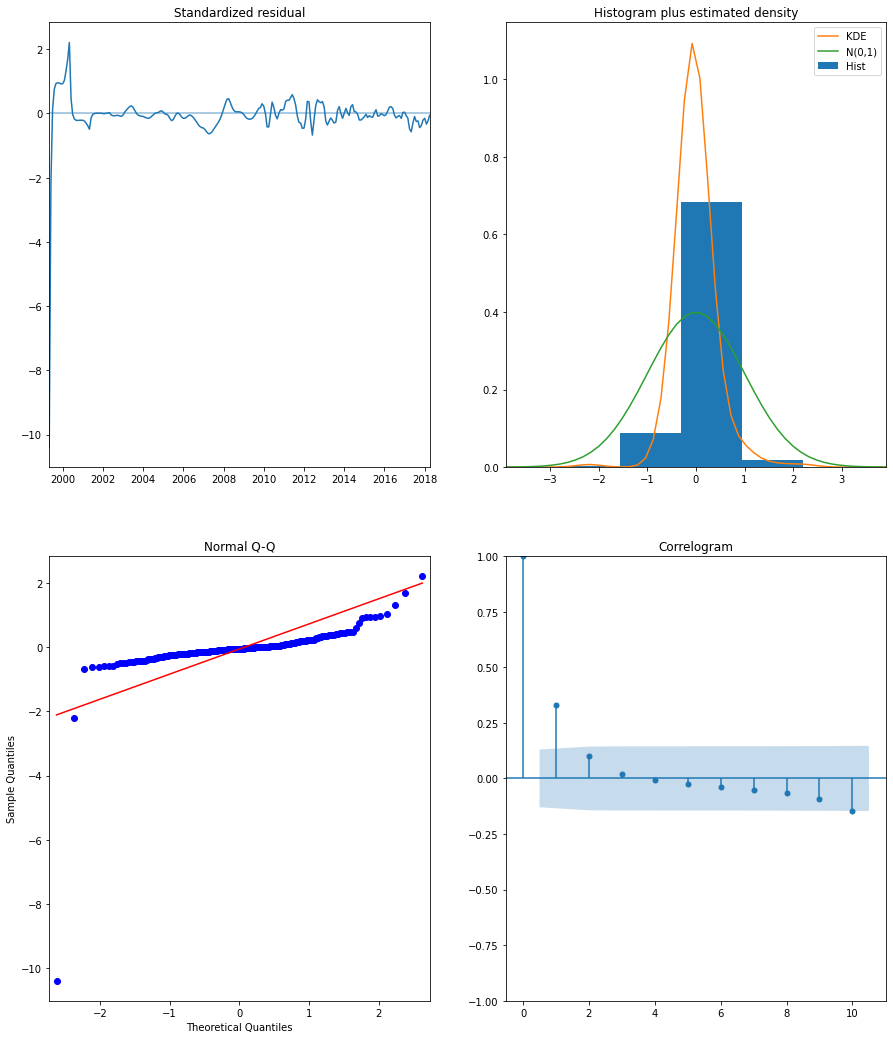

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11216   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2467.708
Date:                            Thu, 17 Dec 2020   AIC                           4941.416
Time:                                    20:25:29   BIC                           4951.846
Sample:                                04-01-1996   HQIC                          4945.619
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7842      0.036     21.985      0.000       0.714       0.854
ma.S.L12      -0.4963      0.028    -17.758      0.000      -0.551      -0.442
sigma2      7.161e+07   9.82e-11   7.29e+17      0.000    7.16e+07    7.16e+07
===================================================================================
Ljung-Box (Q):                      412.80   Jarque-Bera (JB):               348.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.97   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.06e+32. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


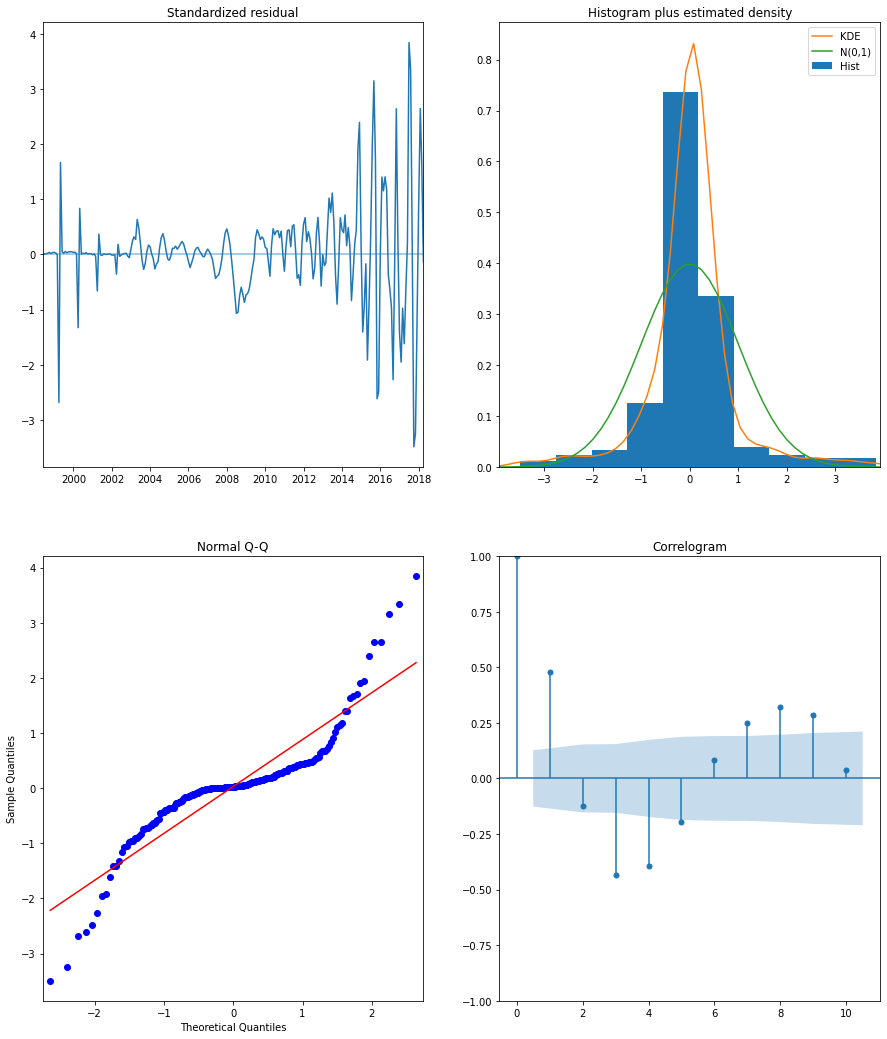

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11210   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood               -3187.494
Date:                            Thu, 17 Dec 2020   AIC                           6382.989
Time:                                    20:25:32   BIC                           6396.911
Sample:                                04-01-1996   HQIC                          6388.598
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0279      0.003    358.934      0.000       1.022       1.033
ar.S.L12      -1.4199      0.017    -85.471      0.000      -1.452      -1.387
ma.S.L12      18.1390      0.192     94.485      0.000      17.763      18.515
sigma2      5.418e+07   3.28e-08   1.65e+15      0.000    5.42e+07    5.42e+07
===================================================================================
Ljung-Box (Q):                       63.24   Jarque-Bera (JB):            239442.65
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            11.12
Prob(H) (two-sided):                  0.00   Kurtosis:                       156.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+29. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


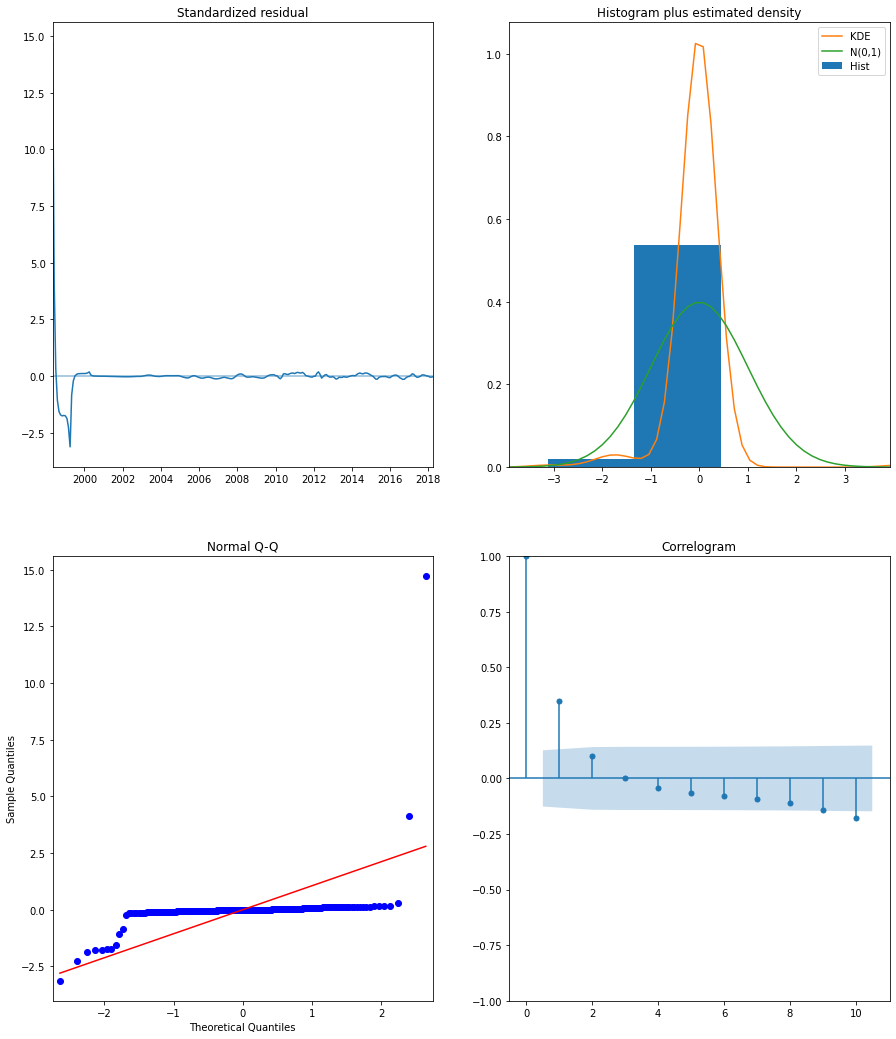

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11224   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(2, 1, 1, 12)   Log Likelihood               -2555.866
Date:                            Thu, 17 Dec 2020   AIC                           5121.732
Time:                                    20:25:36   BIC                           5138.879
Sample:                                04-01-1996   HQIC                          5128.650
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0231      0.009    118.433      0.000       1.006       1.040
ar.S.L12      -1.1814      0.151     -7.828      0.000      -1.477      -0.886
ar.S.L24      -0.1197      0.394     -0.304      0.761      -0.891       0.652
ma.S.L12       3.6491      0.089     40.872      0.000       3.474       3.824
sigma2      3.187e+07   9.52e-09   3.35e+15      0.000    3.19e+07    3.19e+07
===================================================================================
Ljung-Box (Q):                       62.32   Jarque-Bera (JB):            124663.99
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -8.75
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+31. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


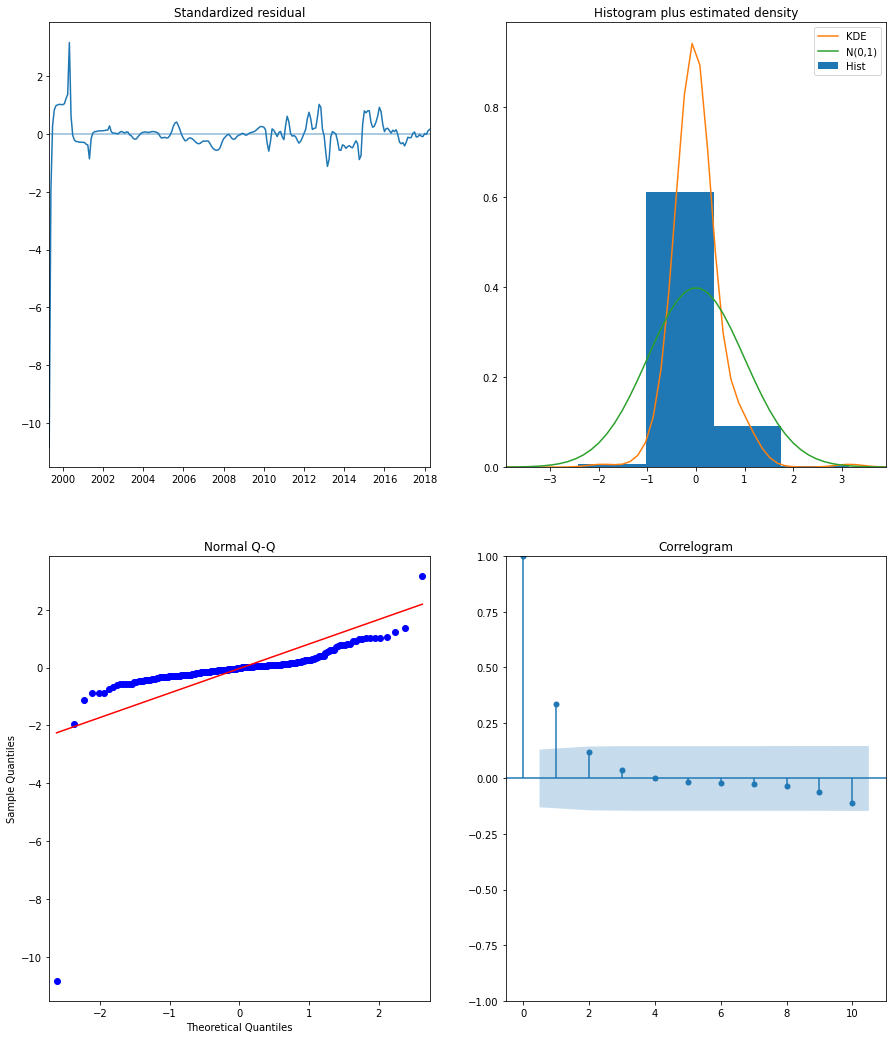

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11222   No. Observations:                  265
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -2573.687
Date:                            Thu, 17 Dec 2020   AIC                           5159.375
Time:                                    20:25:43   BIC                           5180.233
Sample:                                04-01-1996   HQIC                          5167.780
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3080      0.016     80.542      0.000       1.276       1.340
ar.L2         -0.3273      0.018    -17.937      0.000      -0.363      -0.292
ma.L1          0.6042      0.056     10.826      0.000       0.495       0.714
ar.S.L12      -0.7779      0.017    -45.018      0.000      -0.812      -0.744
ma.S.L12       1.3722      0.020     68.366      0.000       1.333       1.412
sigma2      8.104e+07   4.34e-11   1.87e+18      0.000     8.1e+07     8.1e+07
===================================================================================
Ljung-Box (Q):                      272.98   Jarque-Bera (JB):                45.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.04
Prob(H) (two-sided):                  0.20   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.37e+33. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


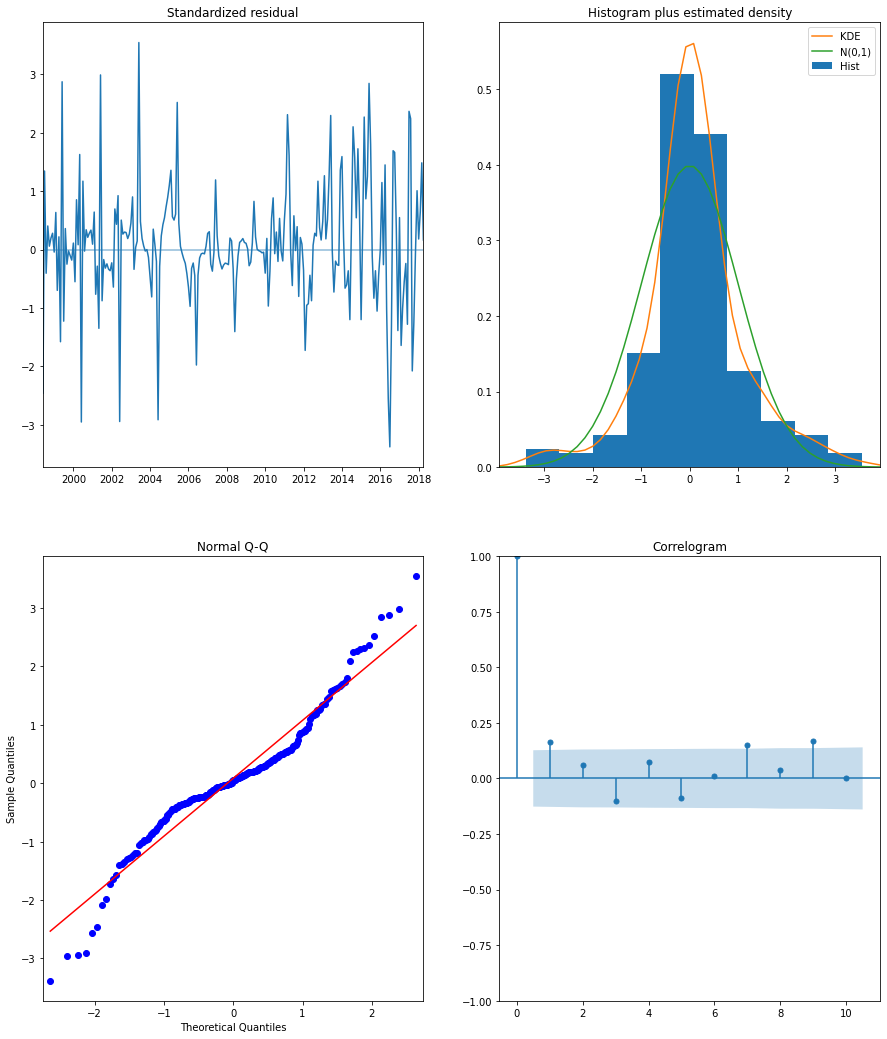

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11228   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 2, 12)   Log Likelihood               -2098.831
Date:                            Thu, 17 Dec 2020   AIC                           4209.661
Time:                                    20:25:49   BIC                           4230.211
Sample:                                04-01-1996   HQIC                          4217.953
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8538      0.044     19.318      0.000       0.767       0.940
ar.S.L12      -0.7228      0.172     -4.191      0.000      -1.061      -0.385
ar.S.L24      -0.4247      0.070     -6.056      0.000      -0.562      -0.287
ma.S.L12      -0.0099      0.154     -0.064      0.949      -0.313       0.293
ma.S.L24      -0.0160      0.127     -0.126      0.900      -0.265       0.233
sigma2       8.53e+06   7.17e+05     11.902      0.000    7.13e+06    9.93e+06
===================================================================================
Ljung-Box (Q):                      243.13   Jarque-Bera (JB):               179.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.91   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


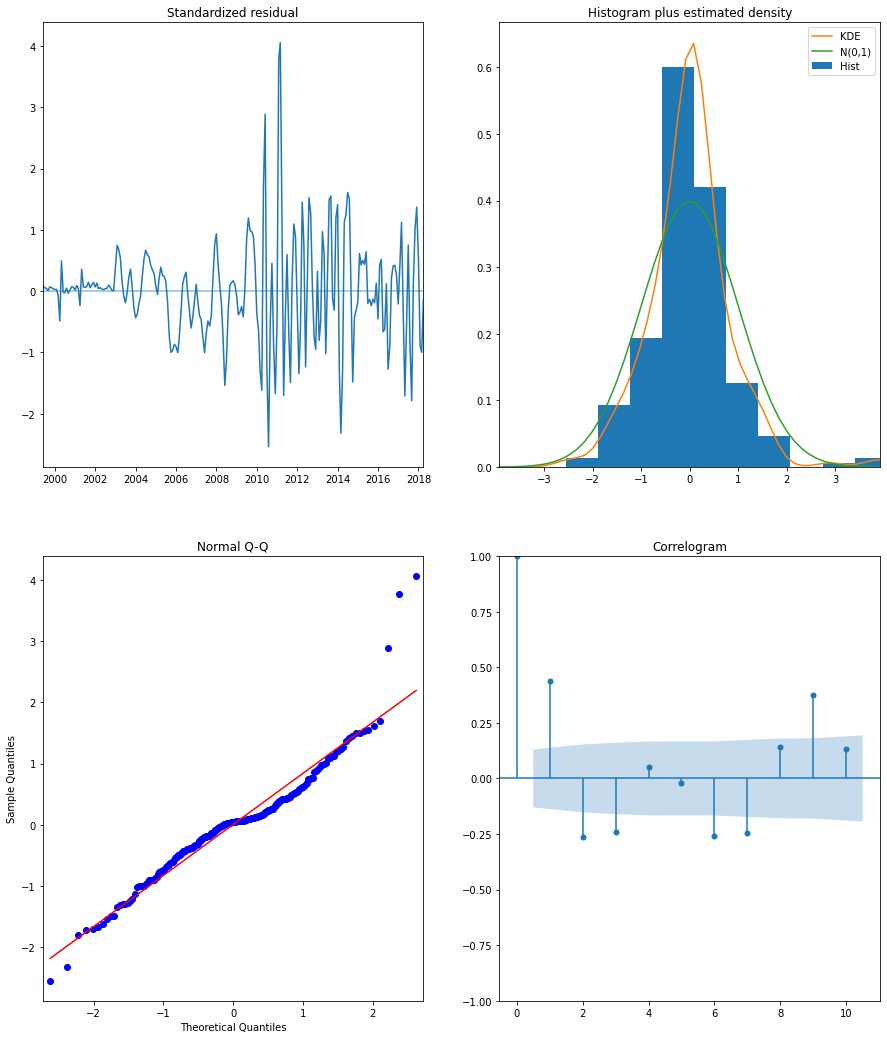

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11238   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood               -2657.123
Date:                            Thu, 17 Dec 2020   AIC                           5322.246
Time:                                    20:25:53   BIC                           5336.168
Sample:                                04-01-1996   HQIC                          5327.856
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0042      0.004    230.875      0.000       0.996       1.013
ar.S.L12      -0.4318      0.091     -4.749      0.000      -0.610      -0.254
ma.S.L12      -0.0472      0.055     -0.865      0.387      -0.154       0.060
sigma2      2.851e+08   1.29e-10    2.2e+18      0.000    2.85e+08    2.85e+08
===================================================================================
Ljung-Box (Q):                      324.72   Jarque-Bera (JB):                15.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.04   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.28e+33. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


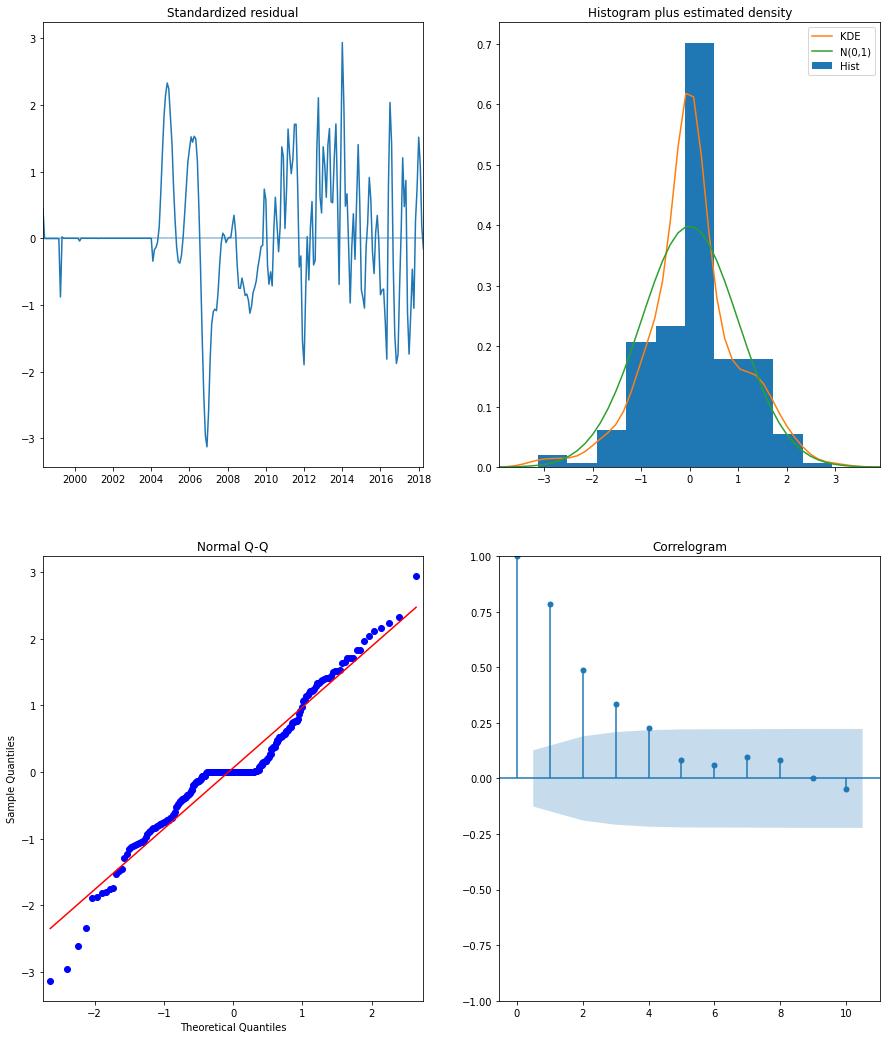

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11205   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 2, 12)   Log Likelihood               -2519.115
Date:                            Thu, 17 Dec 2020   AIC                           5050.230
Time:                                    20:26:00   BIC                           5070.780
Sample:                                04-01-1996   HQIC                          5058.522
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7921      0.045     17.737      0.000       0.705       0.880
ar.S.L12      -0.8557      0.457     -1.872      0.061      -1.752       0.040
ar.S.L24      -0.4415      0.186     -2.379      0.017      -0.805      -0.078
ma.S.L12      -0.0632      0.411     -0.154      0.878      -0.869       0.743
ma.S.L24       0.0109      0.292      0.037      0.970      -0.561       0.583
sigma2       3.78e+08   1.92e-09   1.97e+17      0.000    3.78e+08    3.78e+08
===================================================================================
Ljung-Box (Q):                      136.63   Jarque-Bera (JB):              1839.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              35.63   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+33. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


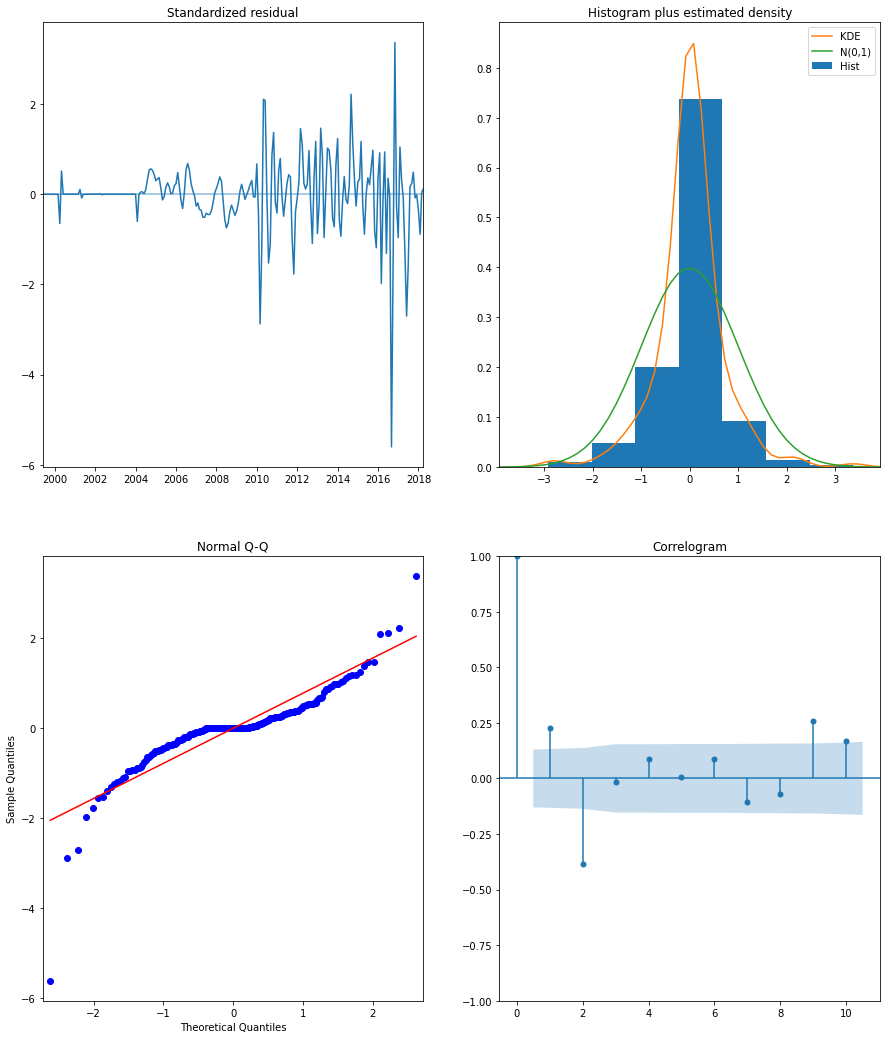

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11217   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2799.331
Date:                            Thu, 17 Dec 2020   AIC                           5600.662
Time:                                    20:26:02   BIC                           5604.187
Sample:                                04-01-1996   HQIC                          5602.081
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.694e+08   1.52e+07     17.690      0.000     2.4e+08    2.99e+08
===================================================================================
Ljung-Box (Q):                      274.35   Jarque-Bera (JB):                64.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             301.40   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


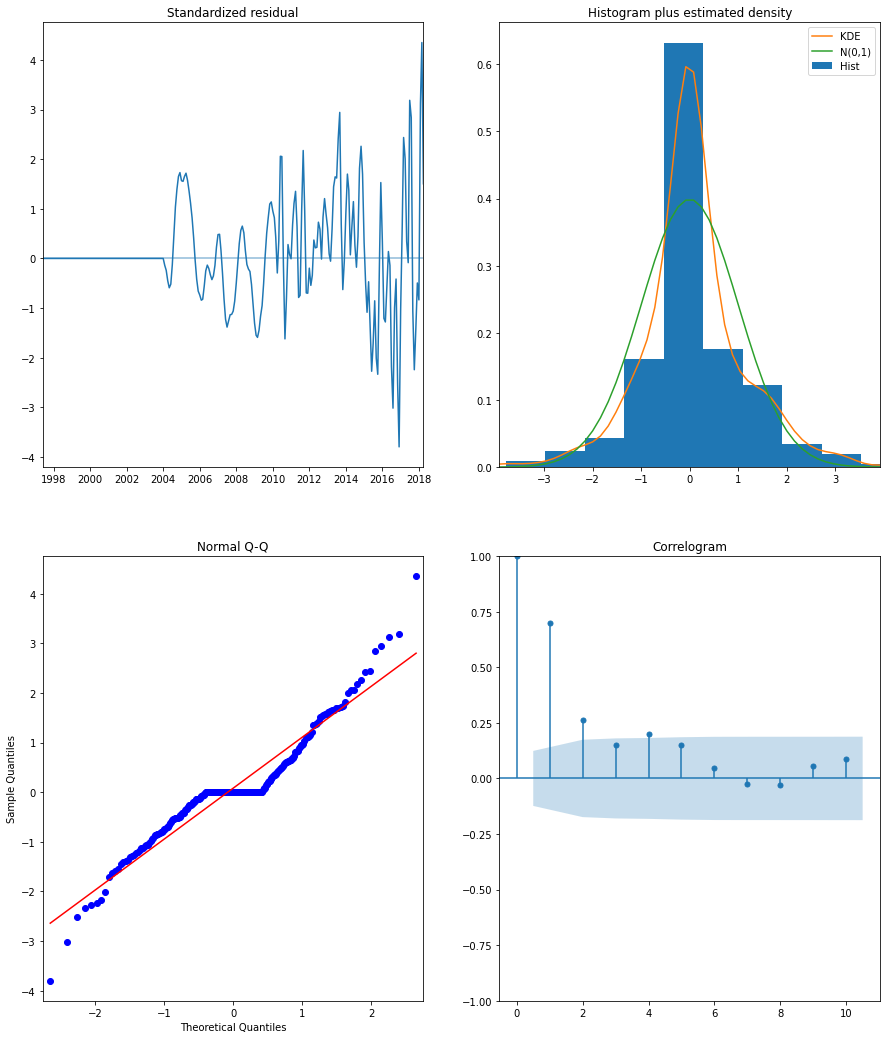

In [74]:
zip_rois={}
steps = 36

#def zipcode_roi(output_df,):
for zipcode in output_df['zipcode'].unique():
  pdq = output_df.loc[ output_df['zipcode']==zipcode, 'pdq'].iloc[0] 
  seasonal = output_df.loc[ output_df['zipcode']==zipcode, 'seasonal_pdq'].iloc[0] 
  df_ts = zip_df[zipcode]


  output_sarima = fit_ARIMA(df_ts, order=pdq, seasonal_order=seasonal)
  prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)
  my_output = my_function(prediction_object, zip=zipcode)
  
  roi_dic = {}

  cost = my_output.iloc[0,0]
  current = my_output.iloc[-1,0]
  current_lower = my_output.iloc[-1,1]
  current_upper = my_output.iloc[-1,2]

  my_roi(cost, current)
  roi_dic['roi'] = my_roi(cost, current)
  roi_dic['roi_lower'] = my_roi(cost, current_lower)
  roi_dic['roi_upper'] = my_roi(cost, current_upper)

  zip_rois[zipcode] = pd.Series(roi_dic)
ROI = pd.DataFrame(zip_rois)

In [75]:
roi_df = ROI.T 
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'zipcode'}, inplace=True)
roi_df.style.background_gradient()

#### **ROI Chart**

In [76]:
roi_chart_1 = roi_df.sort_values(by=['roi'],ascending=False)
#roi_chart_1 = roi_chart_1.round(3)
roi_chart_1.style.background_gradient()

## **Dynamic Forecasting**
Forecasting begins 4-1-2018

In [77]:
def forecast_function(output_df, current_zip=None,steps=None):
  
  # roi_t[roi_t[roi_t.name]== current_zip]
  # print('\n')
  zip_params = output_df[output_df['zipcode']==current_zip]
  zip_params.pdq.values[0]
  zip_params.seasonal_pdq.values[0]

  #steps = 36
  output_sar = fit_ARIMA(zip_df[current_zip], order=zip_params.pdq.values[0], seasonal_order=zip_params.seasonal_pdq.values[0])
  prediction = output_sar.get_forecast(steps=steps, dynamic=True)
  prediction.predicted_mean

  # Get confidence intervals of forecasts
  predict_conf = prediction.conf_int()

  return prediction, predict_conf, current_zip


In [78]:

def forecast_visual(prediction,predict_conf, y, figsize=None):
  """
  prediction-statsmodel object
  predict_conf- pd Dataframe
  """
  print(roi_df[roi_df['zipcode']== current_zip])
  print('\n')
  # Plot future predictions with confidence intervals
  fig,ax = plt.subplots(figsize=figsize)
  ax = y.plot(label='Observed') #(10, 8))
  prediction.predicted_mean.plot(ax=ax, label='Future Forecast')
  ax.fill_between(predict_conf.index,
                  predict_conf.iloc[:, 0],
                  predict_conf.iloc[:, 1], color='k', alpha=0.25)
  
  ax.axvline(prediction.predicted_mean.index[12])

  label_font = {'weight':'bold','size':18}
  ax.set_xlabel('Date',fontdict=label_font)
  ax.set_ylabel('Home Prices',fontdict=label_font)
  ax.set_title(f'Price Forecast for Zipcode: {y.name} /{steps} Months ',fontdict=label_font)

  ax.legend(loc="upper left")

  return ax





### **Zipcode: 11223**
Zipcode 11226 ranks in 1st place for ROI.  The ROI will be 60% on average.<br>
If an investment is made for a return on the lower end the return will be 5.27.<br> 
If a ninvestment is made for a return on the upper end the return will be 86.31.  This will take you into year 2021 and after.<br>
Either way it's a good return on the investment.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11223   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2279.363
Date:                            Thu, 17 Dec 2020   AIC                           4566.726
Time:                                    20:26:05   BIC                           4580.631
Sample:                                04-01-1996   HQIC                          4572.329
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8934      0.036     24.712      0.000       0.823       0.964
ar.S.L12      -0.5475      0.067     -8.229      0.000      -0.678      -0.417
ma.S.L12      -0.0577      0.037     -1.564      0.118      -0.130       0.015
sigma2      1.451e+07   8.46e+05     17.158      0.000    1.29e+07    1.62e+07
===================================================================================
Ljung-Box (Q):                      222.98   Jarque-Bera (JB):               511.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.97   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


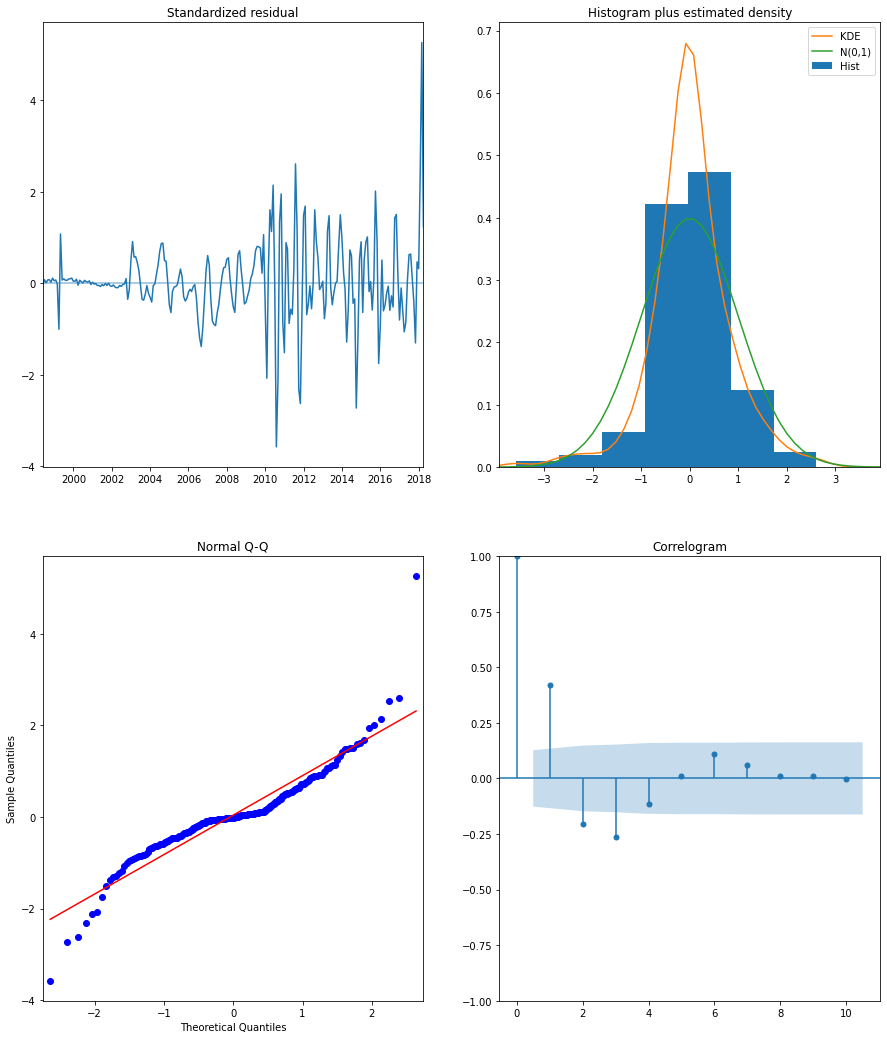

In [79]:
#prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11210, steps=36)
#df_test['Btime'].iloc[0]
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[0], steps=36)

<AxesSubplot:xlabel='Month'>

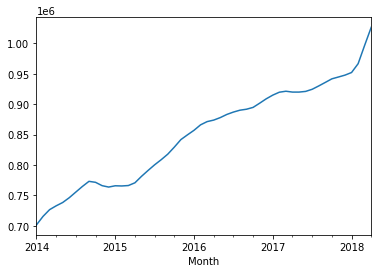

In [80]:
test_brk[roi_chart_1['zipcode'].iloc[0]].plot()

In [81]:
test_brk[roi_chart_1['zipcode'].iloc[0]].describe()

count    5.200000e+01
mean     8.505250e+05
std      8.225949e+04
min      7.013000e+05
25%      7.694750e+05
50%      8.686500e+05
75%      9.199000e+05
max      1.026600e+06
Name: 11223, dtype: float64

    zipcode      roi  roi_lower  roi_upper
14    11223  0.63287   0.162432   1.103308




<AxesSubplot:title={'center':'Price Forecast for Zipcode: 11223 /36 Months '}, xlabel='Date', ylabel='Home Prices'>

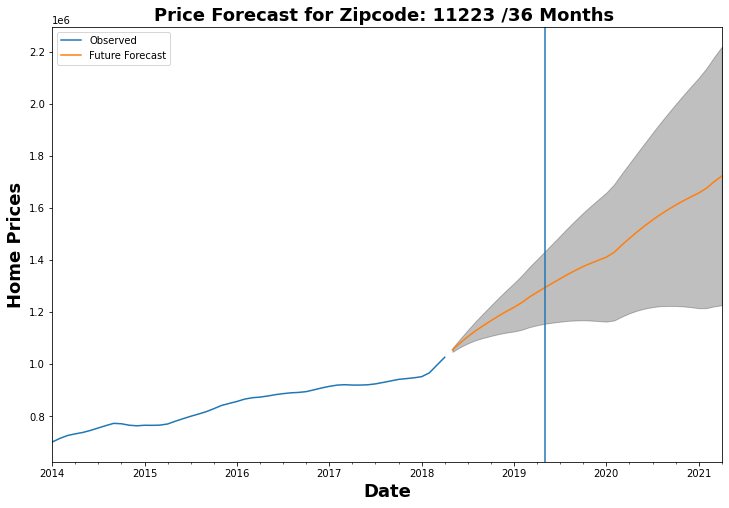

In [82]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[0]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11210**

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11210   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood               -3187.494
Date:                            Thu, 17 Dec 2020   AIC                           6382.989
Time:                                    20:26:10   BIC                           6396.911
Sample:                                04-01-1996   HQIC                          6388.598
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0279      0.003    358.934      0.000       1.022       1.033
ar.S.L12      -1.4199      0.017    -85.471      0.000      -1.452      -1.387
ma.S.L12      18.1390      0.192     94.485      0.000      17.763      18.515
sigma2      5.418e+07   3.28e-08   1.65e+15      0.000    5.42e+07    5.42e+07
===================================================================================
Ljung-Box (Q):                       63.24   Jarque-Bera (JB):            239442.65
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            11.12
Prob(H) (two-sided):                  0.00   Kurtosis:                       156.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+29. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


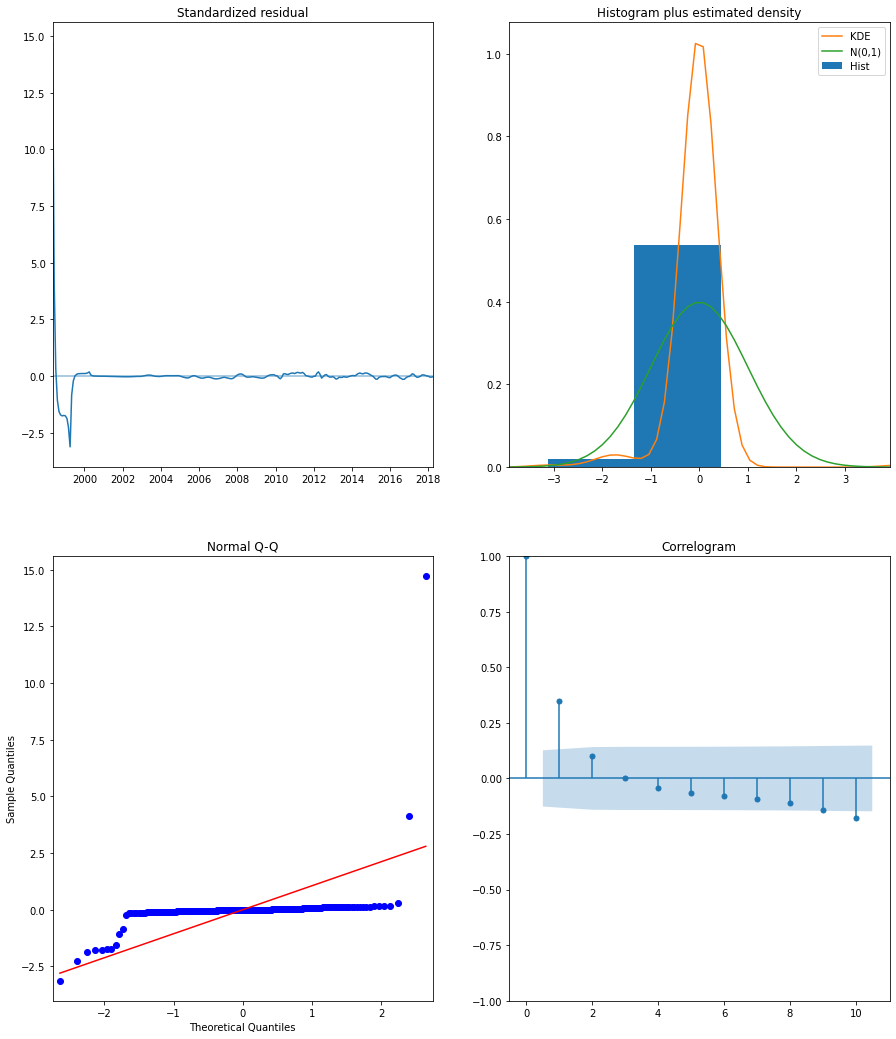

In [83]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[1],steps=36)

In [84]:
test_brk[11233].describe()

count        52.000000
mean     648321.153846
std      128326.946625
min      444700.000000
25%      525800.000000
50%      659000.000000
75%      779125.000000
max      852300.000000
Name: 11233, dtype: float64

<AxesSubplot:xlabel='Month'>

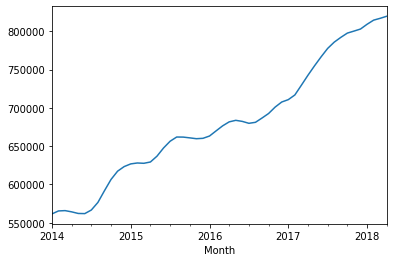

In [85]:
test_brk[roi_chart_1['zipcode'].iloc[1]].plot()

    zipcode       roi  roi_lower  roi_upper
21    11210  0.595686   -3.70768   4.899052




<AxesSubplot:title={'center':'Price Forecast for Zipcode: 11210 /36 Months '}, xlabel='Date', ylabel='Home Prices'>

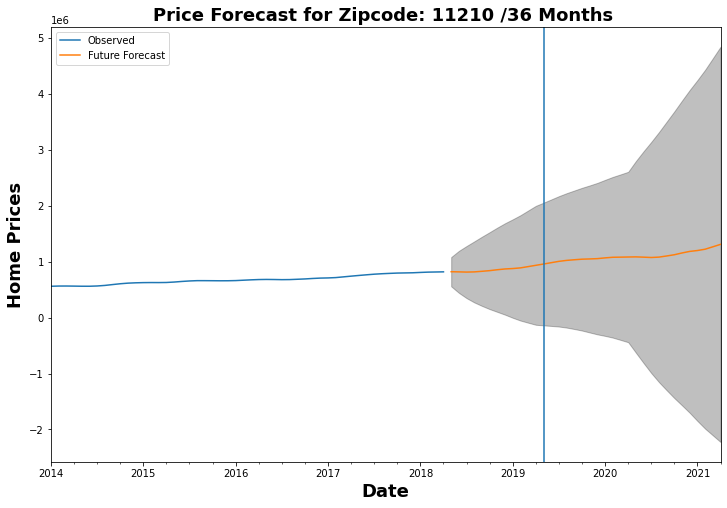

In [86]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[1]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11230**

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11230   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood               -2160.080
Date:                            Thu, 17 Dec 2020   AIC                           4330.159
Time:                                    20:26:14   BIC                           4347.284
Sample:                                04-01-1996   HQIC                          4337.069
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8902      0.043     20.802      0.000       0.806       0.974
ar.S.L12      -0.6404      0.124     -5.179      0.000      -0.883      -0.398
ar.S.L24      -0.2941      0.092     -3.193      0.001      -0.475      -0.114
ma.S.L12      -0.0660      0.082     -0.805      0.421      -0.227       0.095
sigma2      1.367e+07   1.16e+06     11.786      0.000    1.14e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      148.45   Jarque-Bera (JB):                60.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.31   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


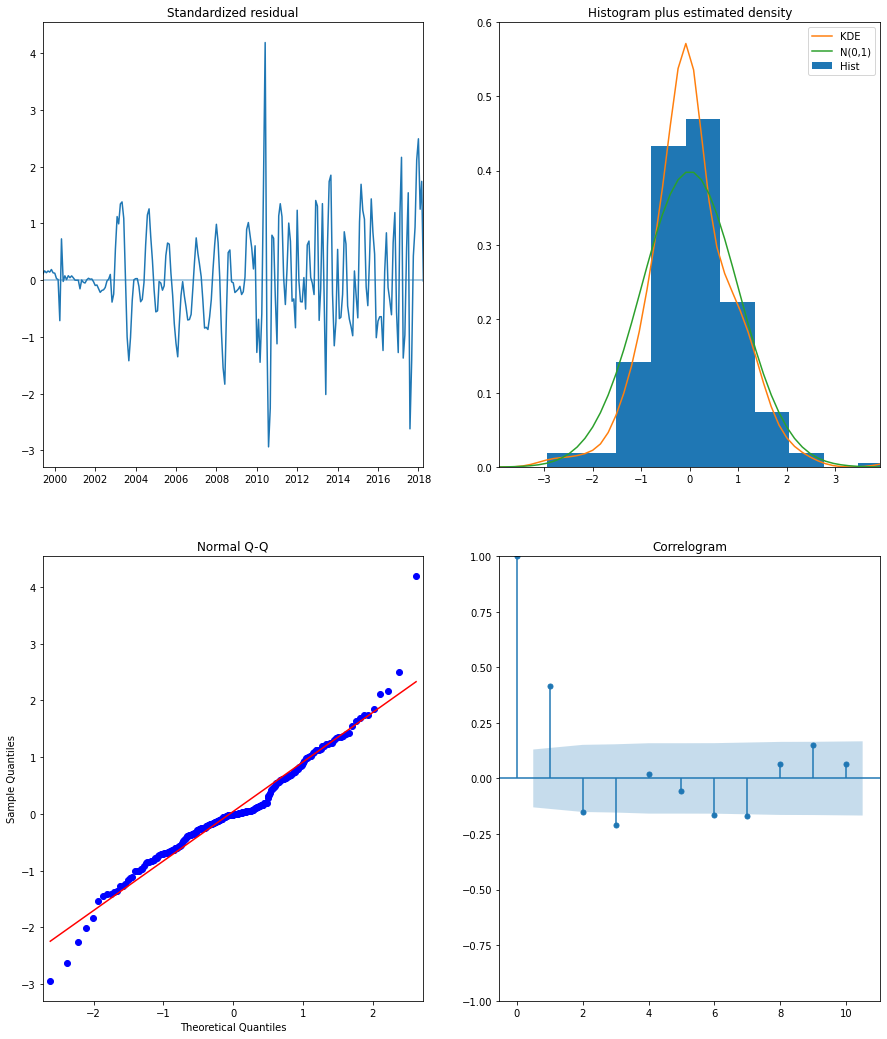

In [87]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[2],steps=36)

In [88]:
test_brk[roi_chart_1['zipcode'].iloc[2]].describe().round(3)

count         52.000
mean      961457.692
std       108811.199
min       819000.000
25%       840225.000
50%       977950.000
75%      1045200.000
max      1195400.000
Name: 11230, dtype: float64

<AxesSubplot:xlabel='Month'>

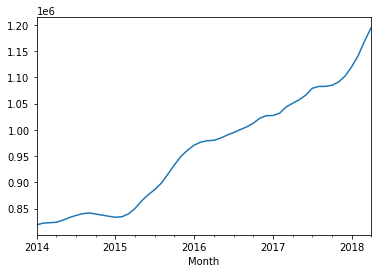

In [89]:
test_brk[roi_chart_1['zipcode'].iloc[2]].plot()

   zipcode      roi  roi_lower  roi_upper
2    11230  0.46778   0.120491   0.815069




<AxesSubplot:title={'center':'Price Forecast for Zipcode: 11230 /36 Months '}, xlabel='Date', ylabel='Home Prices'>

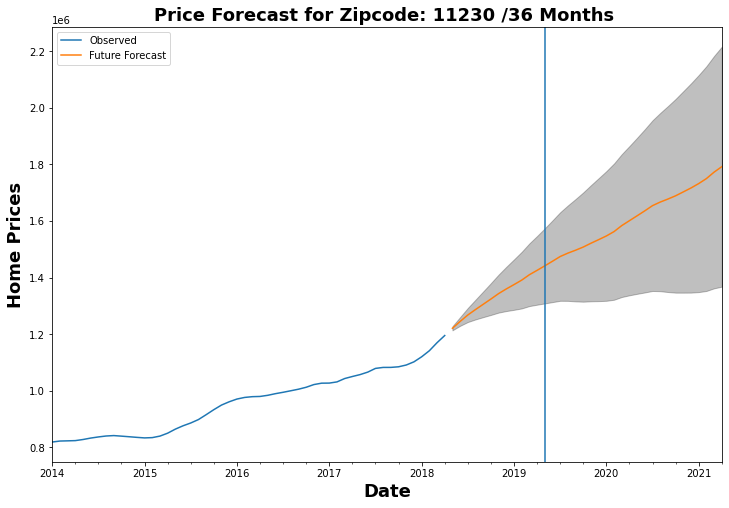

In [90]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[2]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11224**

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11224   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(2, 1, 1, 12)   Log Likelihood               -2555.866
Date:                            Thu, 17 Dec 2020   AIC                           5121.732
Time:                                    20:26:20   BIC                           5138.879
Sample:                                04-01-1996   HQIC                          5128.650
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0231      0.009    118.433      0.000       1.006       1.040
ar.S.L12      -1.1814      0.151     -7.828      0.000      -1.477      -0.886
ar.S.L24      -0.1197      0.394     -0.304      0.761      -0.891       0.652
ma.S.L12       3.6491      0.089     40.872      0.000       3.474       3.824
sigma2      3.187e+07   9.52e-09   3.35e+15      0.000    3.19e+07    3.19e+07
===================================================================================
Ljung-Box (Q):                       62.32   Jarque-Bera (JB):            124663.99
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -8.75
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+31. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


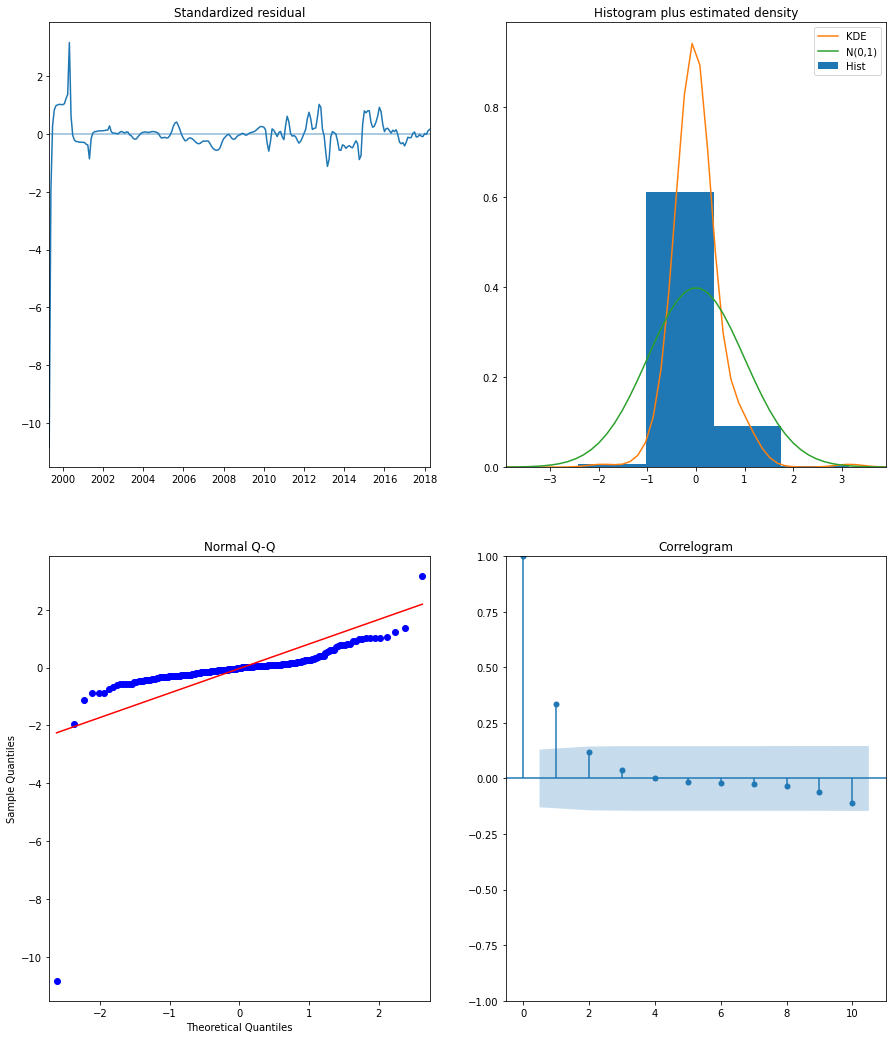

In [91]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[3],steps=36)

In [92]:
test_brk[11230].describe().round(3)

count         52.000
mean      961457.692
std       108811.199
min       819000.000
25%       840225.000
50%       977950.000
75%      1045200.000
max      1195400.000
Name: 11230, dtype: float64

<AxesSubplot:xlabel='Month'>

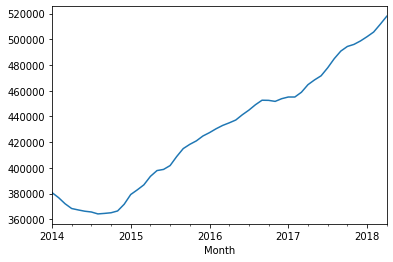

In [93]:
test_brk[roi_chart_1['zipcode'].iloc[3]].plot()

    zipcode       roi  roi_lower  roi_upper
22    11224  0.456346  -0.574688    1.48738




<AxesSubplot:title={'center':'Price Forecast for Zipcode: 11224 /36 Months '}, xlabel='Date', ylabel='Home Prices'>

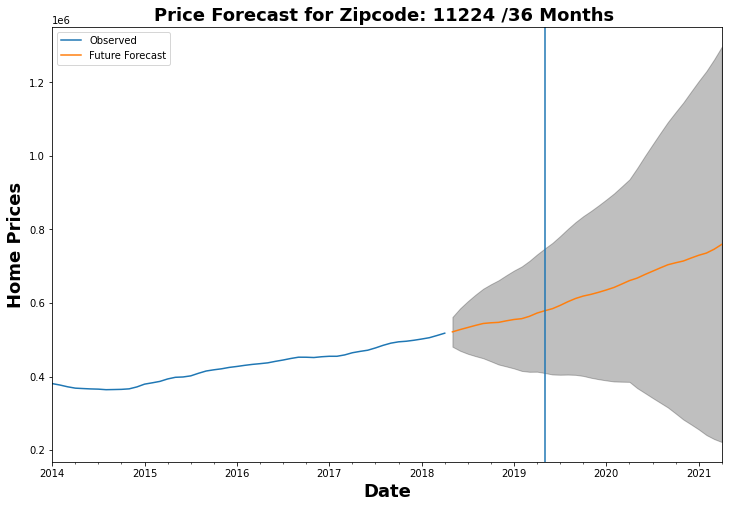

In [94]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[3]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11233**

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              11233   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2299.125
Date:                            Thu, 17 Dec 2020   AIC                           4606.250
Time:                                    20:26:24   BIC                           4620.156
Sample:                                04-01-1996   HQIC                          4611.854
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8020      0.039     20.561      0.000       0.726       0.878
ar.S.L12      -0.6376      0.075     -8.514      0.000      -0.784      -0.491
ma.S.L12      -0.0592      0.075     -0.790      0.429      -0.206       0.088
sigma2      1.724e+07   8.23e-10    2.1e+16      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (Q):                      151.87   Jarque-Bera (JB):               272.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              42.42   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.2e+30. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


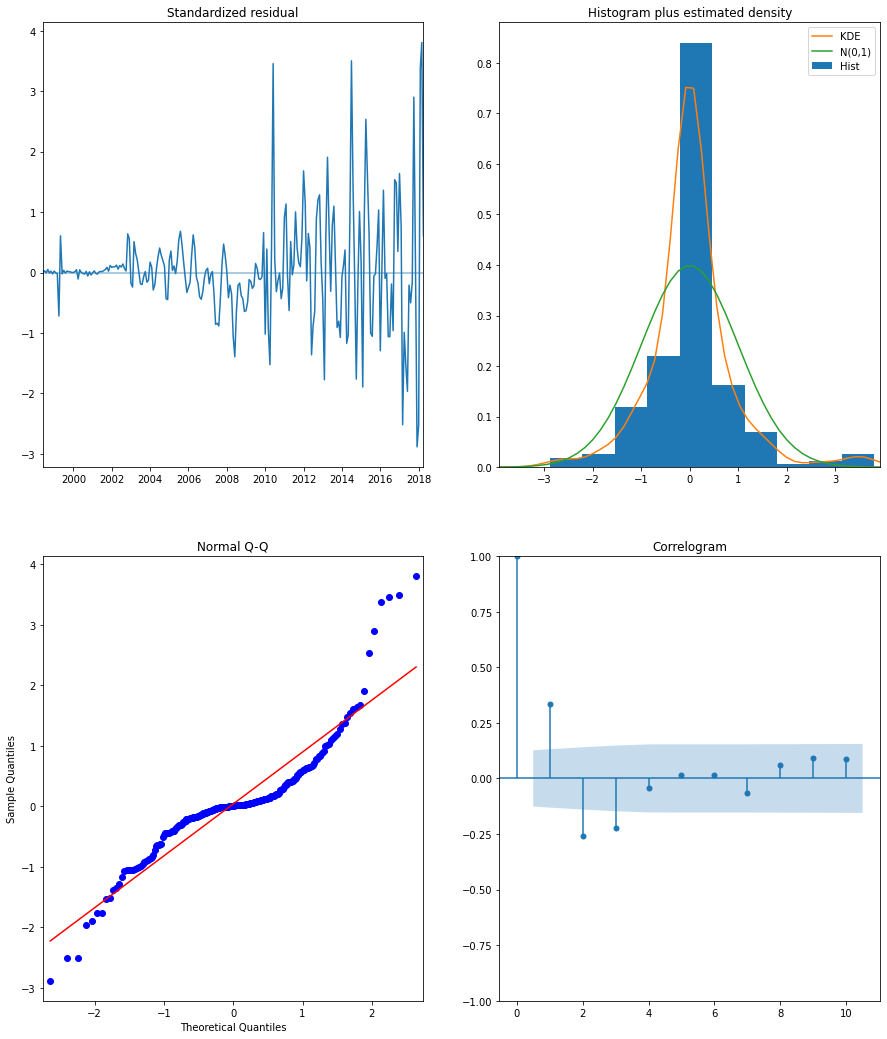

In [95]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[4],steps=36)

In [96]:
test_brk[roi_chart_1['zipcode'].iloc[4]].describe().round(3)

count        52.000
mean     648321.154
std      128326.947
min      444700.000
25%      525800.000
50%      659000.000
75%      779125.000
max      852300.000
Name: 11233, dtype: float64

<AxesSubplot:xlabel='Month'>

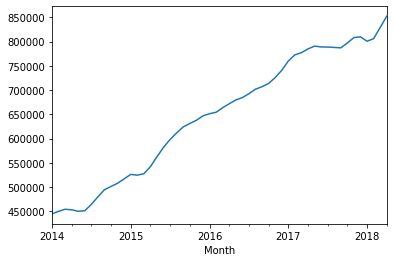

In [97]:
test_brk[roi_chart_1['zipcode'].iloc[4]].plot()

    zipcode       roi  roi_lower  roi_upper
11    11233  0.426736   0.053068   0.800404




<AxesSubplot:title={'center':'Price Forecast for Zipcode: 11233 /36 Months '}, xlabel='Date', ylabel='Home Prices'>

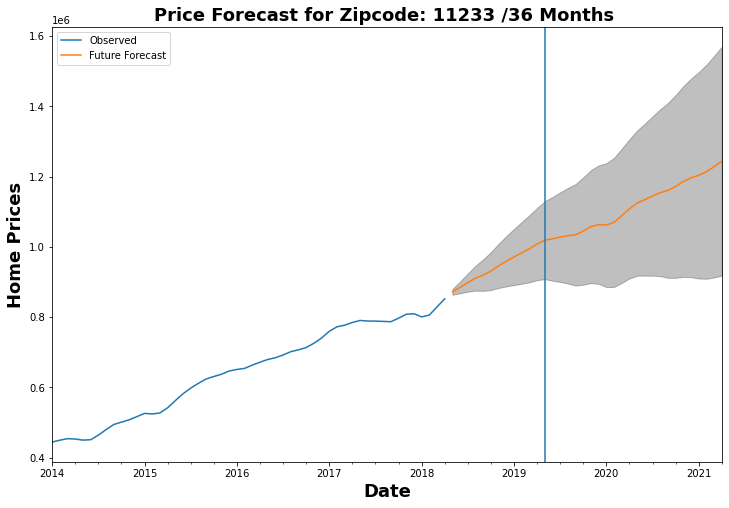

In [98]:

forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[4]], figsize=(12,8))
forecast_visual_zip

## ***Stationarity***

### **Zipcode: 11226**

<AxesSubplot:xlabel='Month'>

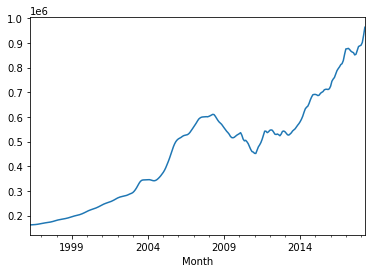

In [99]:
zip_df[11226].plot()

In [100]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

In [102]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [103]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

(0.6254102589740157, 0.9882254867110694, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 4684.550681605726)
Results of Dickey-Fuller Test:
(-0.8284459621478725, 0.8106231633355543, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4266.968811034178)
Results of Dickey-Fuller Test:
(0.223603766489784, 0.9735548149047929, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 4500.304053483356)
Results of Dickey-Fuller Test:
(-1.126284047677486, 0.7044771402246076, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4532.017480354275)
Results of Dickey-Fuller Test:
(-0.8616429826418733, 0.8003414457926942, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 3989.3219246723393)
Results of Dickey-Fuller Test:
(-0.0029477706406218682, 0.958287627523271, 13, 251, {'1%': -3.4566744514553016,

In [104]:
new_dic[11226]

Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

In [105]:

def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [106]:
dickey_fuller_test_zipcodes(zip_df)

Results of Dickey-Fuller Test:
Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -0.828446
p-value                          0.810623
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                   0.223604
p-value                          0.973555
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -

Results of Dickey-Fuller Test:
Test Statistic                   0.885108
p-value                          0.992893
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64




In [107]:
X_1 = zip_df.copy()

In [108]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

ADF statistic: 0.6254102589740157
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic   p-value  #Lags Used  \
AD Fuller Results         0.62541  0.988225          15   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     249               False

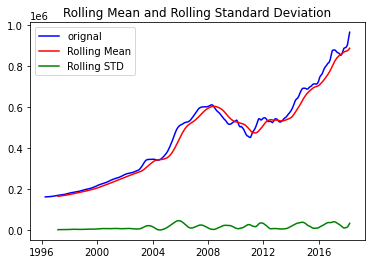

In [109]:
stationary_test(zip_df[11226])

###  Zipcode:  11238

In [110]:
#brooklyn_zips[11226]

In [111]:
#stationary_test(zip_df[11238])

### Zipcode:  11215

ADF statistic: 0.6254102589740157
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic   p-value  #Lags Used  \
AD Fuller Results         0.62541  0.988225          15   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     249               False

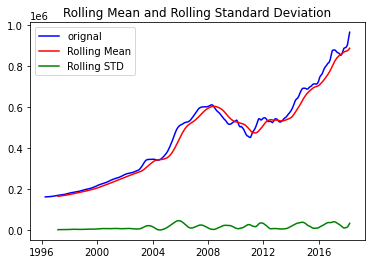

In [112]:
stationary_test(zip_df[11226])

### Removing Trend
#### Log-Transformation (np.log)

ADF statistic: -0.8965122806314477
p-value: 0.7891188037192395
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic   p-value  #Lags Used  \
AD Fuller Results       -0.896512  0.789119          15   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     249               False

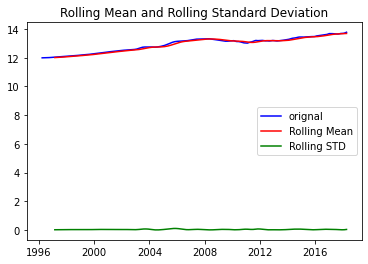

In [113]:
## Log Transform
ts3 = np.log(zip_df[11226])
#ts3.plot()
stationary_test(ts3)

#### Differencing

ADF statistic: -2.077602274942009
p-value: 0.253615678699624
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic   p-value  #Lags Used  \
AD Fuller Results       -2.077602  0.253616          14   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     249               False

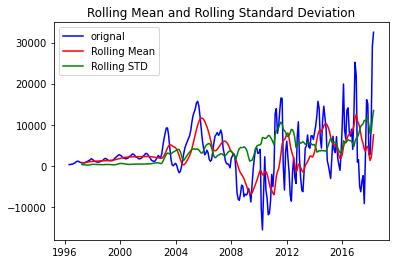

In [114]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11226].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

ADF statistic: -1.6919221784675258
p-value: 0.43527914575985616
Critical Values:
	1% : -3.457215237265747
	5% : -2.873361841566324
	10% : -2.5730700760129555


Test Statistic   p-value  #Lags Used  \
AD Fuller Results       -1.691922  0.435279          16   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     246               False

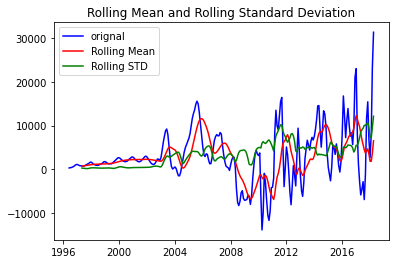

In [115]:
## Subtract Rolling mean
ts2 = (zip_df[11226] - zip_df[11226].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

ADF statistic: -1.3861610987959605
p-value: 0.5888923863309322
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic   p-value  #Lags Used  \
AD Fuller Results       -1.386161  0.588892          15   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     249               False

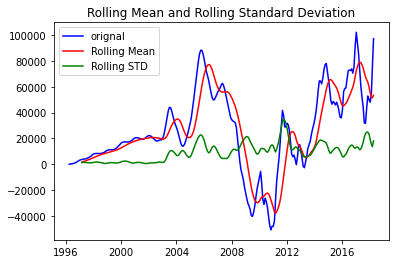

In [116]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11226] - zip_df[11226].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

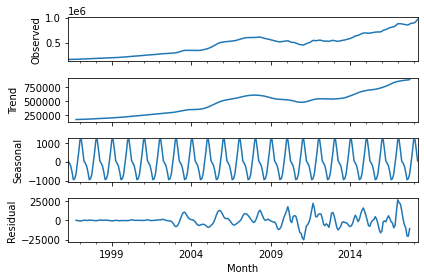

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11226])#,model='mul')
decomp.plot();

ADF statistic: -1397610076326336.0
p-value: 0.0
Critical Values:
	1% : -3.456780859712
	5% : -2.8731715065600003
	10% : -2.572968544


Test Statistic  p-value  #Lags Used  \
AD Fuller Results   -1.397610e+15      0.0          14   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     250                True

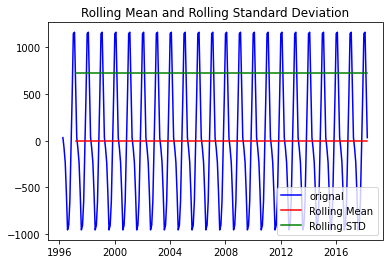

In [118]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

ADF statistic: 0.7040604444127804
p-value: 0.9899185553239931
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


Test Statistic   p-value  #Lags Used  \
AD Fuller Results         0.70406  0.989919          16   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     236               False

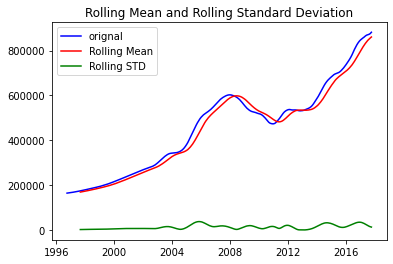

In [119]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

ADF statistic: -4.6808902052492245
p-value: 9.139086370902431e-05
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


Test Statistic   p-value  #Lags Used  \
AD Fuller Results        -4.68089  0.000091          16   

                   # of Observations Used  Stationary Results  
AD Fuller Results                     236                True

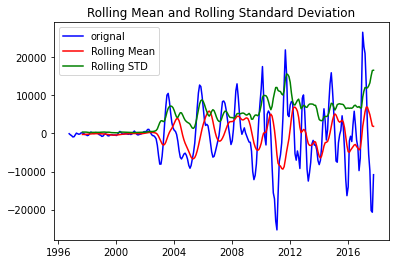

In [120]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [121]:
decomp.resid.dropna()

Month
1996-10-01      -66.765873
1996-11-01     -359.478716
1996-12-01     -561.859668
1997-01-01     -915.827922
1997-02-01     -855.113636
                  ...     
2017-06-01    -5596.978716
2017-07-01    -9750.550144
2017-08-01   -20252.534271
2017-09-01   -20681.700938
2017-10-01   -10825.099206
Freq: MS, Name: 11226, Length: 253, dtype: float64

## **RNN**

In [122]:
df_rnn = zip_df[[11238]]

In [123]:
df_rnn.head()

11238
Month               
1996-04-01  671200.0
1996-05-01  671200.0
1996-06-01  671200.0
1996-07-01  671200.0
1996-08-01  671200.0

<AxesSubplot:xlabel='Month'>

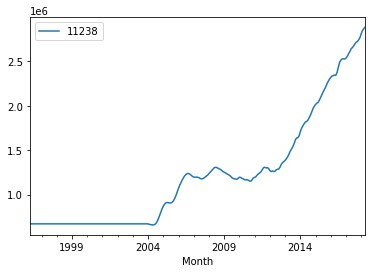

In [124]:
df_rnn.plot()

In [125]:
len(df_rnn)

265

In [126]:
265-12

253

In [127]:
"""
x_train= x_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
"""
train = df_rnn.iloc[:253]
test = df_rnn.iloc[253:]
#test = test.reshape(1, -1)
#train= train.reshape(-1, 1)

In [128]:
test

11238
Month                
2017-05-01  2639900.0
2017-06-01  2655700.0
2017-07-01  2673300.0
2017-08-01  2696700.0
2017-09-01  2716500.0
2017-10-01  2724000.0
2017-11-01  2744300.0
2017-12-01  2768900.0
2018-01-01  2810700.0
2018-02-01  2848100.0
2018-03-01  2869600.0
2018-04-01  2885300.0

In [129]:
len(test)

12

In [130]:
train.shape

(253, 1)

In [131]:
from sklearn.preprocessing import MinMaxScaler

In [132]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [133]:
scaled_train

array([[6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],


In [134]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [135]:
n_input = 2
n_features = 1 #smaller batch sizes lead to better training

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [136]:
scaled_train[:5]

array([[0.00615006],
       [0.00615006],
       [0.00615006],
       [0.00615006],
       [0.00615006]])

In [137]:
len(scaled_train)

253

In [138]:
"""

253 - n_input(2)

"""
len(generator)

251

In [139]:
#create model and fit it to the generator object
from keras.models import Sequential
from keras.layers import Dense  #for final output later
from keras.layers import LSTM #long short term memory

In [140]:
n_input = 12 #look at full year of data or 12 months before predicting 13th month
n_features = 1 #smaller batch sizes lead to better training
               #how many columns you have. WE have 1 column which is time stamp for y

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [141]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#need to aggregate all the neurons to sngle prediciton
model.add(Dense(1)) #added single dense neuron which will directly output our prediction
model.compile(optimizer='adam', loss='mse')

In [142]:
"""
may want to play around w/number of neurons on LSTM layer
"""
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [143]:
"""
fit tou our training generator
more epochs you use hte longer it's going to take to train
1 epoch is a single entire run through of training data

We get significant reduciton over 1st couple of epochs then around 15 start seeing convergence

"""
model.fit_generator(train_generator, epochs=25)

Epoch 1/25
241/241 [==============================] - 7s 31ms/step - loss: 0.0101
Epoch 2/25
241/241 [==============================] - 6s 26ms/step - loss: 0.0011
Epoch 3/25
241/241 [==============================] - 5s 23ms/step - loss: 8.4803e-04
Epoch 4/25
241/241 [==============================] - 7s 28ms/step - loss: 0.0012
Epoch 5/25
241/241 [==============================] - 6s 25ms/step - loss: 8.1325e-04
Epoch 6/25
241/241 [==============================] - 6s 27ms/step - loss: 5.3463e-04
Epoch 7/25
241/241 [==============================] - 6s 25ms/step - loss: 0.0014
Epoch 8/25
241/241 [==============================] - 5s 21ms/step - loss: 5.5889e-04
Epoch 9/25
241/241 [==============================] - 6s 25ms/step - loss: 5.2105e-04
Epoch 10/25
241/241 [==============================] - 7s 28ms/step - loss: 3.6556e-04
Epoch 11/25
241/241 [==============================] - 6s 25ms/step - loss: 5.5271e-04
Epoch 12/25
241/241 [==============================] - 6s 24ms/step 

In [144]:
model.history.history.keys()

dict_keys(['loss'])

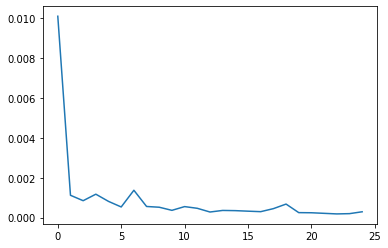

In [145]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss']);

In [146]:
"""
evalute on the test data
create an evlauation batch
our network trains 1 step ahead

our network is 12 network steps 
    then predict step 13
    
need last 12 points of training data inorder to predict pt. 1 of test data 

these are last 12 points of training set
"""
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.86341738],
       [0.88104756],
       [0.91149036],
       [0.93890939],
       [0.95126076],
       [0.95807708],
       [0.95879459],
       [0.95756458],
       [0.96258713],
       [0.97263223],
       [0.98708487],
       [1.        ]])

In [147]:
"""
it now has 3 brackets at the top
"""
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))
first_eval_batch

array([[[0.86341738],
        [0.88104756],
        [0.91149036],
        [0.93890939],
        [0.95126076],
        [0.95807708],
        [0.95879459],
        [0.95756458],
        [0.96258713],
        [0.97263223],
        [0.98708487],
        [1.        ]]])

In [148]:
"""
call model on first_eval_batch
gives array prediciton
means given these 12 points of training data it predicts taht below should be 1st point of test data set
"""
model.predict(first_eval_batch)

array([[1.0010606]], dtype=float32)

In [149]:
scaled_test

array([[1.0151189 ],
       [1.02321648],
       [1.03223657],
       [1.04422919],
       [1.05437679],
       [1.05822058],
       [1.06862444],
       [1.08123206],
       [1.10265478],
       [1.12182247],
       [1.13284133],
       [1.14088766]])

In [150]:
"""
not just predict 1st point in test set but the entire test set
how to forecast into the future
Forecast using RNN model
"""
#hold predicitons
test_predictions = []
#last n_input points from training set
first_eval_batch = scaled_train[-n_input:] 
#reshape to format of RNN wants, (same format as Timeseriesgenerator 
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#hoe far into the futrue will I forecast: length of test set
for i in range(len(test)):
    #1time step ahead of historical 12 points
    current_pred = model.predict(current_batch)[0] #0 is for formatting 
    test_predictions.append(current_pred)
    
    #update current batch to include prediciton
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [151]:
test_predictions

[array([1.0010606], dtype=float32),
 array([1.0085137], dtype=float32),
 array([1.0146279], dtype=float32),
 array([1.0201536], dtype=float32),
 array([1.0255103], dtype=float32),
 array([1.0308038], dtype=float32),
 array([1.0358665], dtype=float32),
 array([1.0407501], dtype=float32),
 array([1.0454772], dtype=float32),
 array([1.0500662], dtype=float32),
 array([1.0545363], dtype=float32),
 array([1.0589043], dtype=float32)]

In [152]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[2612469.45257187],
       [2627011.91005707],
       [2638942.02384949],
       [2649723.78568649],
       [2660175.71907043],
       [2670504.37383652],
       [2680382.71274567],
       [2689911.68470383],
       [2699135.01873016],
       [2708089.2332077 ],
       [2716811.3117218 ],
       [2725334.05103683]])

In [153]:
test['Predictions'] = true_predictions

In [154]:
test

11238   Predictions
Month                              
2017-05-01  2639900.0  2.612469e+06
2017-06-01  2655700.0  2.627012e+06
2017-07-01  2673300.0  2.638942e+06
2017-08-01  2696700.0  2.649724e+06
2017-09-01  2716500.0  2.660176e+06
2017-10-01  2724000.0  2.670504e+06
2017-11-01  2744300.0  2.680383e+06
2017-12-01  2768900.0  2.689912e+06
2018-01-01  2810700.0  2.699135e+06
2018-02-01  2848100.0  2.708089e+06
2018-03-01  2869600.0  2.716811e+06
2018-04-01  2885300.0  2.725334e+06

### **RNN Plot / Sales v Predicted Values**

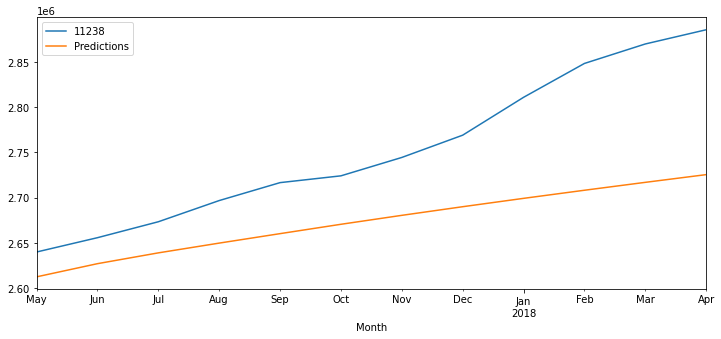

In [155]:
"""
sales v predicted values
"""
test.plot(figsize=(12,5));

### **Recommendations**
Below are the Brooklyn zipcodes with the predicted Top 5 ROIs which I would recommend investing in:<br>
11223  (63%)<br>
11210  (59%)<br>
11230  (46%)<br>
11224  (45%)<br>
11233  (42%)<br>